# DATASETS LOADING


In [609]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, uniform, triang, laplace, logistic, kstest
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Define file paths
dataset_path = r'C:\Users\rafae\OneDrive\Documents\CAPTSTONE\dailyActivity_merged_def.csv'
heartbeat_path = r'C:\Users\rafae\OneDrive\Documents\CAPTSTONE\heartrate_seconds_merged.csv'
met_path = r'C:\Users\rafae\OneDrive\Documents\CAPTSTONE\minuteMETsNarrow_merged.csv'
sleep_path = r'C:\Users\rafae\OneDrive\Documents\CAPTSTONE\sleepDay_merged.csv'

# List of file paths
file_paths = [dataset_path, heartbeat_path, met_path, sleep_path]

# Function to check if files exist
def check_files_exist(file_paths):
    """
    Check if all files in the provided list exist.
    
    Parameters:
    file_paths (list): List of file paths to check.

    Returns:
    bool or tuple: True if all files exist, otherwise False and list of missing files.
    """
    missing_files = [file for file in file_paths if not os.path.isfile(file)]
    if not missing_files:
        return True
    else:
        return False, missing_files

# Check if all files exist
result = check_files_exist(file_paths)
if result is True:
    # Load the CSV files
    dataset = pd.read_csv(dataset_path)
    heartbeat = pd.read_csv(heartbeat_path)
    met_data = pd.read_csv(met_path)
    sleep_data = pd.read_csv(sleep_path)
    print("All files loaded correctly.")
else:
    print("Missing files:", result[1])




All files loaded correctly.


# HEARBEAT MERGING

In [610]:
# Convert the 'Time' column in heartbeat to datetime format
heartbeat['Time'] = pd.to_datetime(heartbeat['Time'])

# Extract the date from the 'Time' column in heartbeat
heartbeat['Date'] = heartbeat['Time'].dt.date

# Group by 'Id' and 'Date' and calculate the max value
summary_heartbeat = heartbeat.groupby(['Id', 'Date']).agg(
    Heartbeat_Max_Value=('Value', 'max'),
    Heartbeat_Min_Value=('Value', 'min'),
    Heartbeat_Avg_Value=('Value', 'mean')    
).reset_index()

# Convert the 'ActivityDate' column in dataset to datetime format if it's not already
dataset['ActivityDate'] = pd.to_datetime(dataset['ActivityDate']).dt.date

# Merge the dataset and summary_heartbeat DataFrames on 'Id' and 'ActivityDate' (renaming 'Date' to 'ActivityDate' in summary_heartbeat)
summary_heartbeat.rename(columns={'Date': 'ActivityDate'}, inplace=True)
merged_dataset = pd.merge(dataset, summary_heartbeat, on=['Id', 'ActivityDate'], how='left')

# Check if the merge was successful
if not merged_dataset.empty:
    print("Merging completed successfully.")
else:
    print("Merging failed. The resulting DataFrame is empty.")


Merging completed successfully.


# MET MERGING 

In [611]:
# Convert the 'ActivityMinute' column in met_data to datetime format
met_data['ActivityMinute'] = pd.to_datetime(met_data['ActivityMinute'])

# Extract the date from the 'ActivityMinute' column in met_data
met_data['Date'] = met_data['ActivityMinute'].dt.date

# Group by 'Id' and 'Date' and calculate the max, min, and average METs
summary_met = met_data.groupby(['Id', 'Date']).agg(
    Max_METs=('METs', 'max'),
    Min_METs=('METs', 'min'),
    Avg_METs=('METs', 'mean')
).reset_index()

# Rename 'Date' to 'ActivityDate' in summary_met for merging
summary_met.rename(columns={'Date': 'ActivityDate'}, inplace=True)

# Merge the summary_met DataFrame with the merged_dataset
final_merged_dataset = pd.merge(merged_dataset, summary_met, on=['Id', 'ActivityDate'], how='left')

# Check if the merge was successful
if not final_merged_dataset.empty:
    print("Final merging completed successfully.")
else:
    print("Final merging failed. The resulting DataFrame is empty.")

Final merging completed successfully.


# SLEEP MERGING 

In [612]:
# Convert the 'SleepDay' column in sleep_data to datetime format if it's not already
sleep_data['SleepDay'] = pd.to_datetime(sleep_data['SleepDay']).dt.date

# Merge the sleep_data DataFrame with the final_merged_dataset on 'Id' and 'ActivityDate'/'SleepDay'
all_merged_data = pd.merge(final_merged_dataset, sleep_data, left_on=['Id', 'ActivityDate'], right_on=['Id', 'SleepDay'], how='left')

# Drop the redundant 'SleepDay' column
all_merged_data.drop(columns=['SleepDay'], inplace=True)

# Check if the final merge was successful
if not all_merged_data.empty:
    print("All merging completed successfully.")
else:
    print("All merging failed. The resulting DataFrame is empty.")
        

All merging completed successfully.


In [613]:
# Eliminate observations where SedentaryMinutes is 1440 (24 hrs)
# When the sedentary minute is 1440 mins (24 hrs), there are no records in any group. Proceed to eliminate this.
all_merged_data = all_merged_data[all_merged_data['SedentaryMinutes'] != 1440]

# Eliminate users that have less than 50% of records required, meaning less than 15 records.
# Count the number of records for each user
user_counts = all_merged_data['Id'].value_counts()

# Get valid users who have at least 15 records
valid_users = user_counts[user_counts >= 15].index

# Keep only the records of valid users
all_merged_data = all_merged_data[all_merged_data['Id'].isin(valid_users)]

# Save the DataFrame to an Excel file
excel_file_path = 'all_merged_data.xlsx'
all_merged_data.to_excel(excel_file_path, index=False)
print(f"File saved as {excel_file_path}")

File saved as all_merged_data.xlsx


In [614]:
# Exclude 'Id' and 'ActivityDate' columns
data_for_summary = all_merged_data.drop(columns=['Id', 'ActivityDate'])

# Generate summary statistics using describe()
summary_statistics = data_for_summary.describe(include='all')

# Add mode, variance, and missing values to the summary statistics
mode_values = data_for_summary.mode().iloc[0]
variance = data_for_summary.var()
missing_values = data_for_summary.isnull().sum()
total_rows = len(data_for_summary)
missing_percentage = (missing_values / total_rows) * 100

# Create a DataFrame to hold additional statistics
additional_stats = pd.DataFrame({
    'Mode': mode_values,
    'Variance': variance,
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})

# Concatenate the additional statistics with the describe() output
summary_df = pd.concat([summary_statistics.T, additional_stats], axis=1)

# Display the summary DataFrame
print(summary_df)




                          count         mean          std        min          25%          50%           75%           max         Mode      Variance  Missing Values  Missing Percentage
TotalSteps                856.0  8353.257009  4757.505320   4.000000  4928.250000  8078.500000  11114.000000  36019.000000   244.000000  2.263386e+07               5            0.580720
TotalDistance             855.0     6.011088     3.731344   0.010000     3.380000     5.630000      7.985000     28.030001     0.010000  1.392292e+01               6            0.696864
TrackerDistance           855.0     5.995310     3.713508   0.010000     3.380000     5.630000      7.915000     28.030001     0.010000  1.379014e+01               6            0.696864
VeryActiveDistance        855.0     1.658901     2.744878   0.000000     0.000000     0.450000      2.295000     21.920000     0.000000  7.534357e+00               6            0.696864
ModeratelyActiveDistance  855.0     0.629333     0.909262   0.000000  

# DEFINING THE GROUPS OF COLUMNS

In [615]:
# Define the groups of columns
activity_columns = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance', 'VeryActiveDistance', 
    'ModeratelyActiveDistance', 'LightActiveDistance', 'VeryActiveMinutes', 
    'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 
    'Calories'
]

sleep_columns = [
    'TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'
]

heartbeat_columns = [
    'Heartbeat_Max_Value', 'Heartbeat_Min_Value', 'Heartbeat_Avg_Value'
]

met_columns = [
    'Max_METs', 'Min_METs', 'Avg_METs'
]

# Define the groups of columns
activity_columns = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance', 'VeryActiveDistance', 
    'ModeratelyActiveDistance', 'LightActiveDistance', 'VeryActiveMinutes', 
    'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 
    'Calories'
]

sleep_columns = [
    'TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'
]

heartbeat_columns = [
    'Heartbeat_Max_Value', 'Heartbeat_Min_Value', 'Heartbeat_Avg_Value'
]

met_columns = [
    'Max_METs', 'Min_METs', 'Avg_METs'
]


In [616]:
# Check for missing data in each group
all_merged_data['Activity_Record_Missing'] = all_merged_data[activity_columns].isnull().any(axis=1)
all_merged_data['Sleep_Record_Missing'] = all_merged_data[sleep_columns].isnull().any(axis=1)
all_merged_data['Heartbeat_Record_Missing'] = all_merged_data[heartbeat_columns].isnull().any(axis=1)
all_merged_data['Met_Record_Missing'] = all_merged_data[met_columns].isnull().any(axis=1)

# Calculate missing counts for each user
missing_counts = all_merged_data.groupby('Id').agg(
    Total_Records=('Id', 'size'),
    Activity_Record_Missing=('Activity_Record_Missing', 'sum'),
    Sleep_Record_Missing=('Sleep_Record_Missing', 'sum'),
    Heartbeat_Record_Missing=('Heartbeat_Record_Missing', 'sum'),
    Met_Record_Missing=('Met_Record_Missing', 'sum')
).reset_index()

# Calculate the percentage of actual records for each group based on 31, excluding NaN
missing_counts['Activity_Record_Actual_Percent'] = ((1 - missing_counts['Activity_Record_Missing'] / 31) * 100).round(2)
missing_counts['Sleep_Record_Actual_Percent'] = ((1 - missing_counts['Sleep_Record_Missing'] / 31) * 100).round(2)
missing_counts['Heartbeat_Record_Actual_Percent'] = ((1 - missing_counts['Heartbeat_Record_Missing'] / 31) * 100).round(2)
missing_counts['METs_Record_Actual_Percent'] = ((1 - missing_counts['Met_Record_Missing'] / 31) * 100).round(2)

# Create a summary table with both counts and percentages
summary_table = missing_counts[['Id', 'Activity_Record_Missing', 'Activity_Record_Actual_Percent',
                                'Sleep_Record_Missing', 'Sleep_Record_Actual_Percent',
                                'Heartbeat_Record_Missing', 'Heartbeat_Record_Actual_Percent',
                                'Met_Record_Missing', 'METs_Record_Actual_Percent']]

# Add a column to count the total number of groups where the percentage of missing values is higher or equal to 40%
summary_table['Total_Groups_above_40_Percent'] = (summary_table[
    ['Activity_Record_Actual_Percent', 'Sleep_Record_Actual_Percent', 
     'Heartbeat_Record_Actual_Percent', 'METs_Record_Actual_Percent']] >= 40).sum(axis=1)

# Display the summary table
print(summary_table)


            Id  Activity_Record_Missing  Activity_Record_Actual_Percent  Sleep_Record_Missing  Sleep_Record_Actual_Percent  Heartbeat_Record_Missing  Heartbeat_Record_Actual_Percent  Met_Record_Missing  METs_Record_Actual_Percent  Total_Groups_above_40_Percent
0   1503960366                        0                          100.00                     5                        83.87                        30                             3.23                   0                      100.00                              3
1   1624580081                        0                          100.00                    31                         0.00                        31                             0.00                   0                      100.00                              2
2   1644430081                        0                          100.00                    26                        16.13                        30                             3.23                   0                

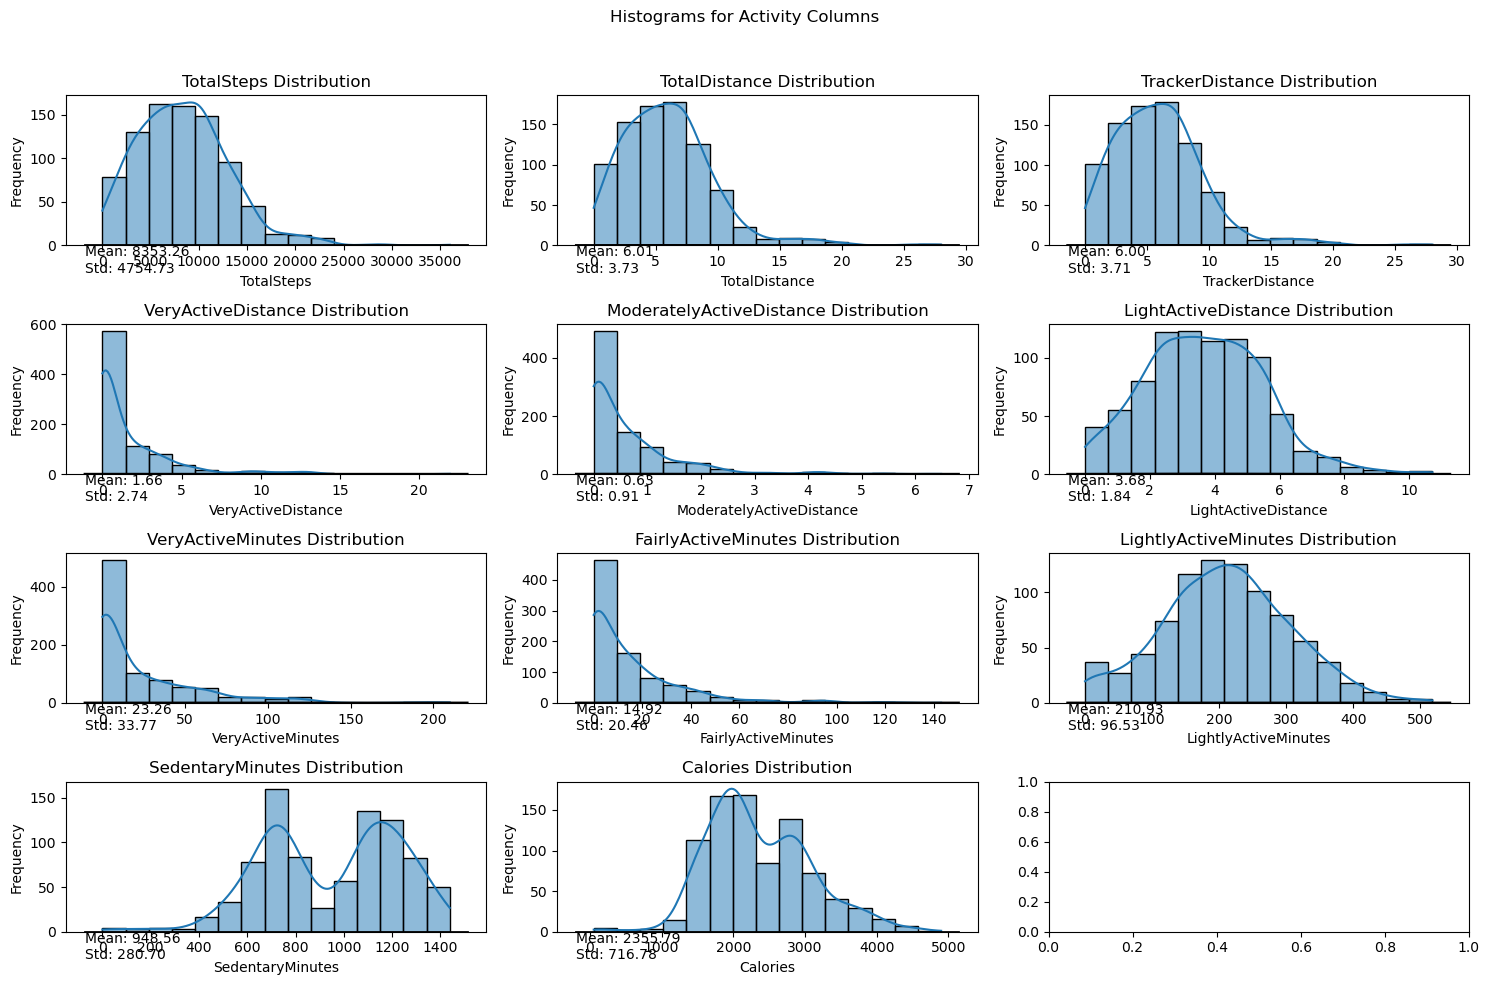

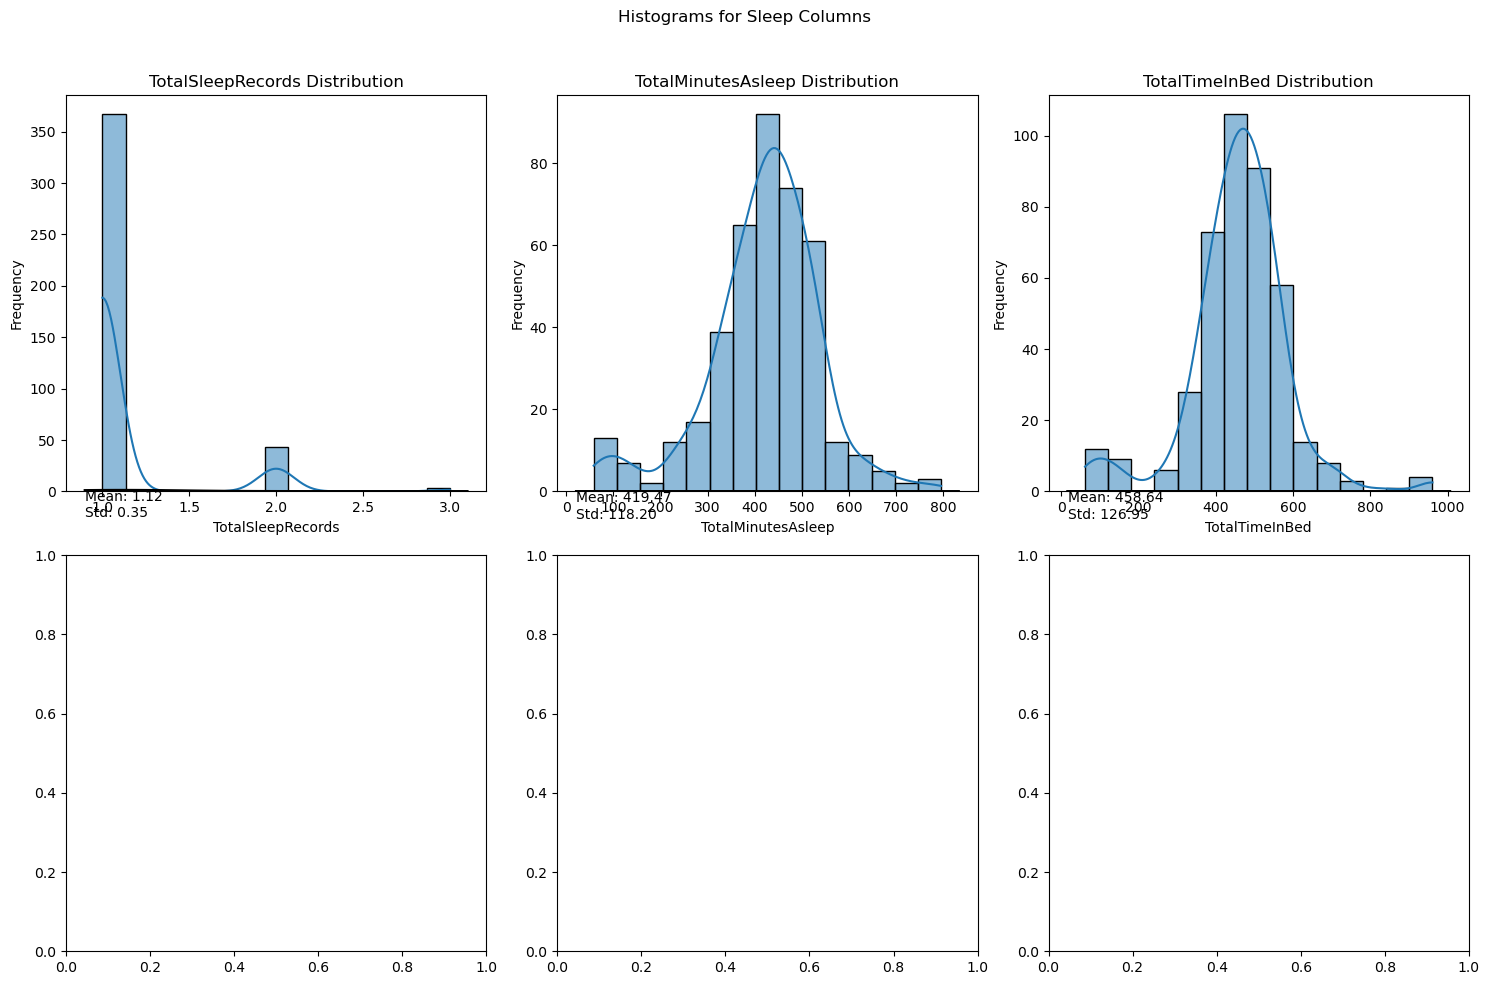

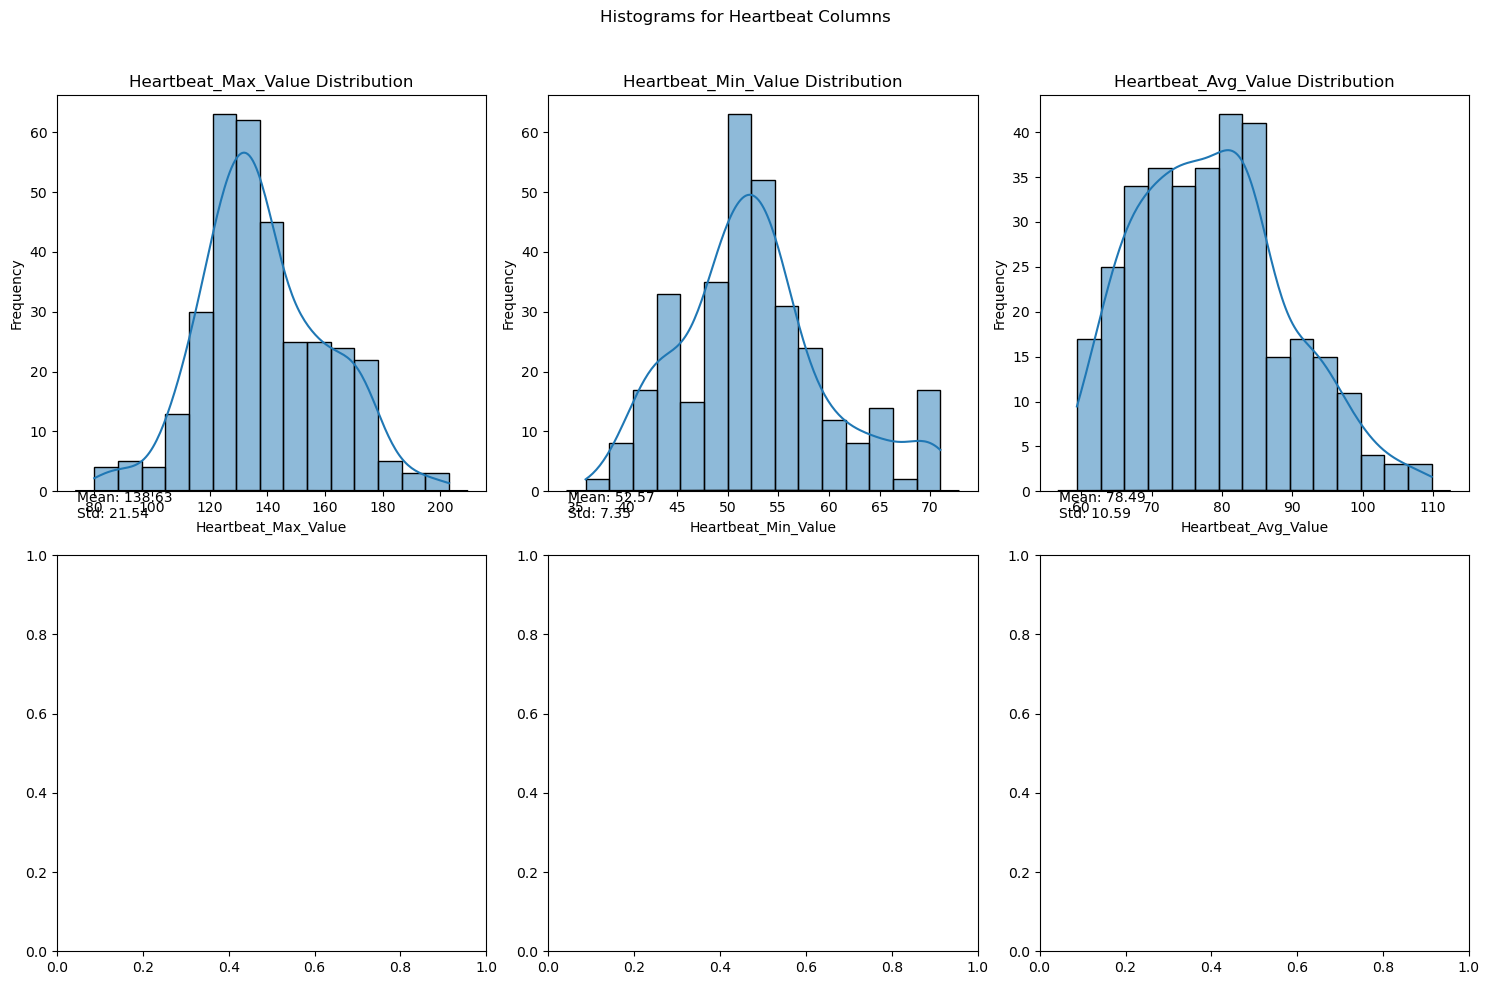

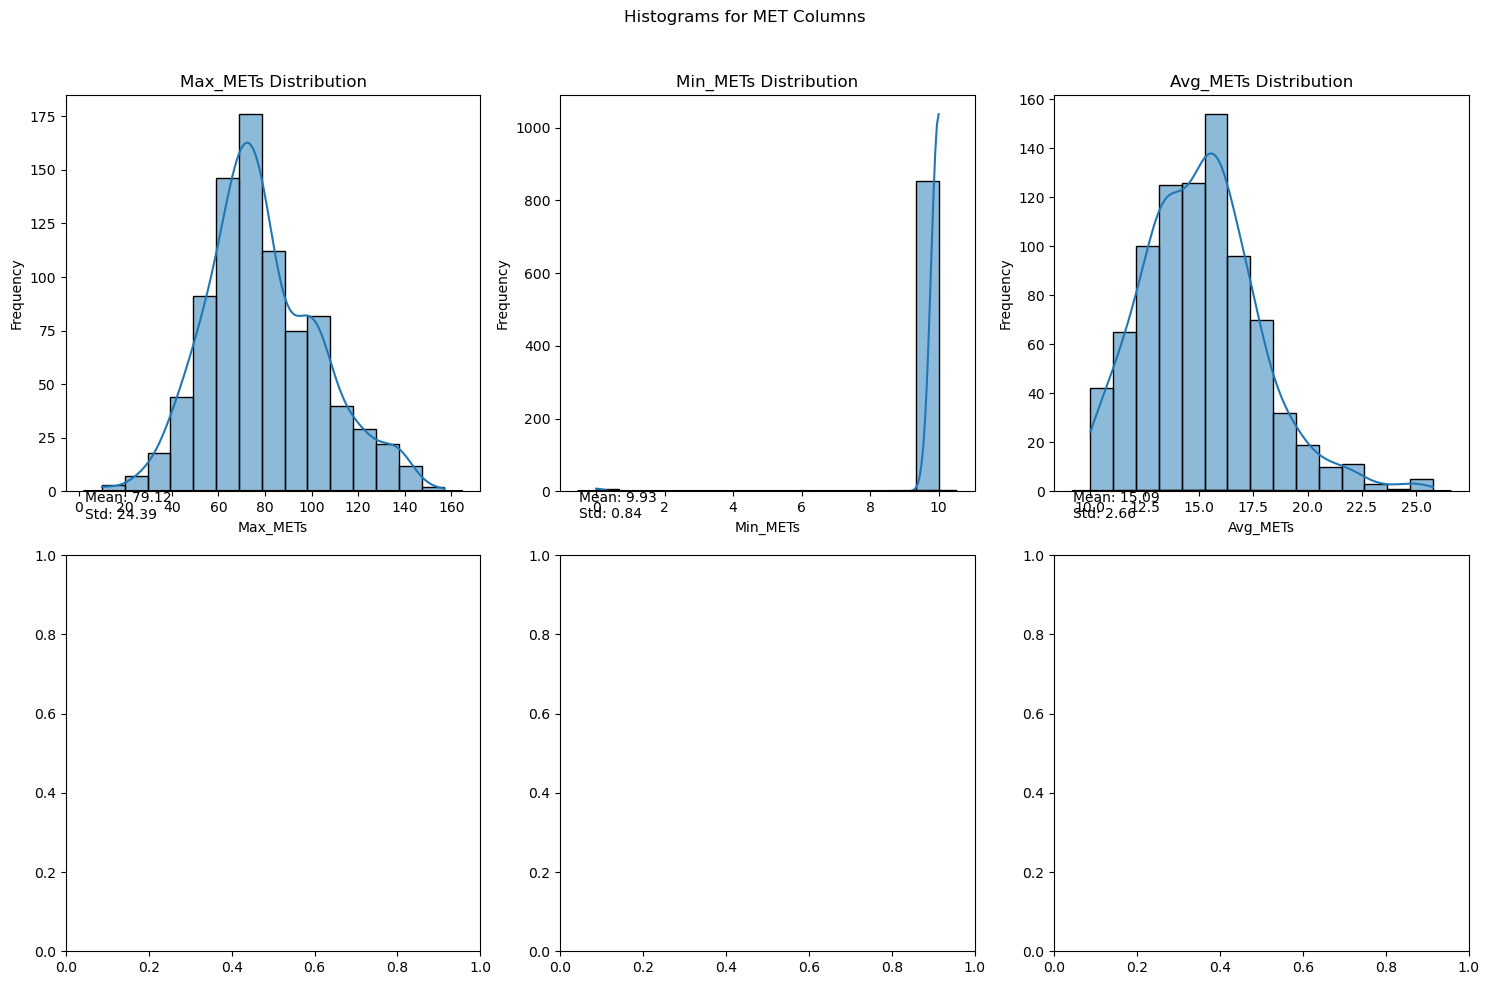

In [617]:
# Function to plot histograms for a list of columns
def plot_histograms(data, columns, group_name):
    num_columns = len(columns)
    fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(data[col], bins=15, kde=True, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        
        # Fit a normal distribution and plot the PDF
        mu, std = stats.norm.fit(data[col].dropna())
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        axes[i].plot(x, p, 'k', linewidth=2)
        axes[i].text(xmin, max(p), f'Mean: {mu:.2f}\nStd: {std:.2f}', fontsize=10, verticalalignment='top')
    
    plt.suptitle(f'Histograms for {group_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot histograms for each group
plot_histograms(all_merged_data, activity_columns, 'Activity Columns')
plot_histograms(all_merged_data, sleep_columns, 'Sleep Columns')
plot_histograms(all_merged_data, heartbeat_columns, 'Heartbeat Columns')
plot_histograms(all_merged_data, met_columns, 'MET Columns')

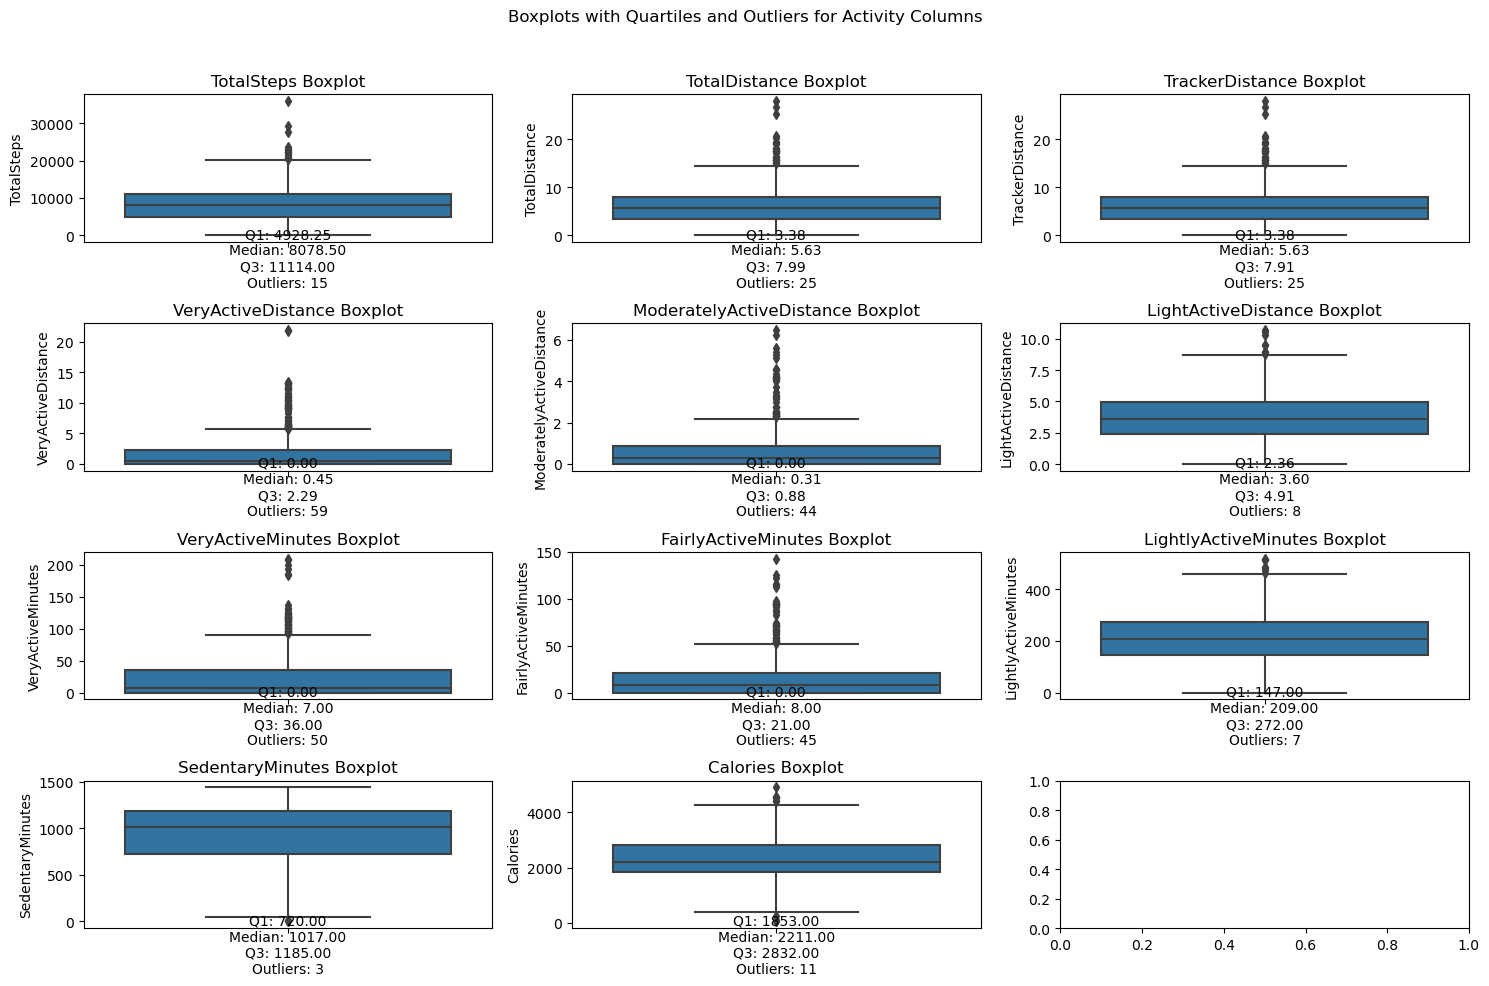

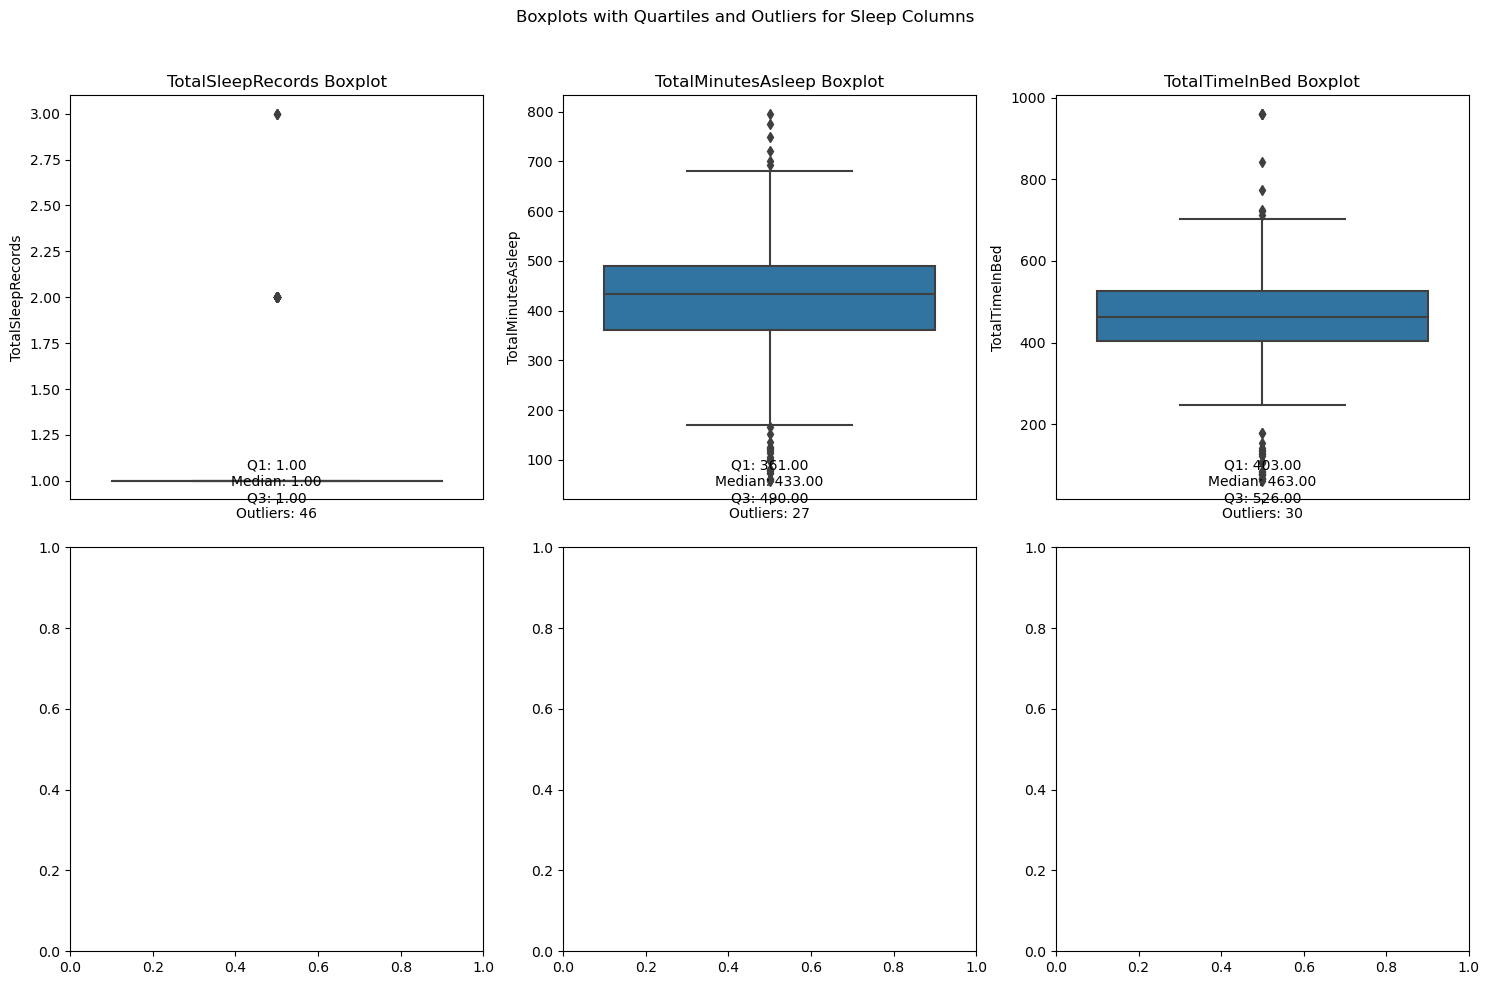

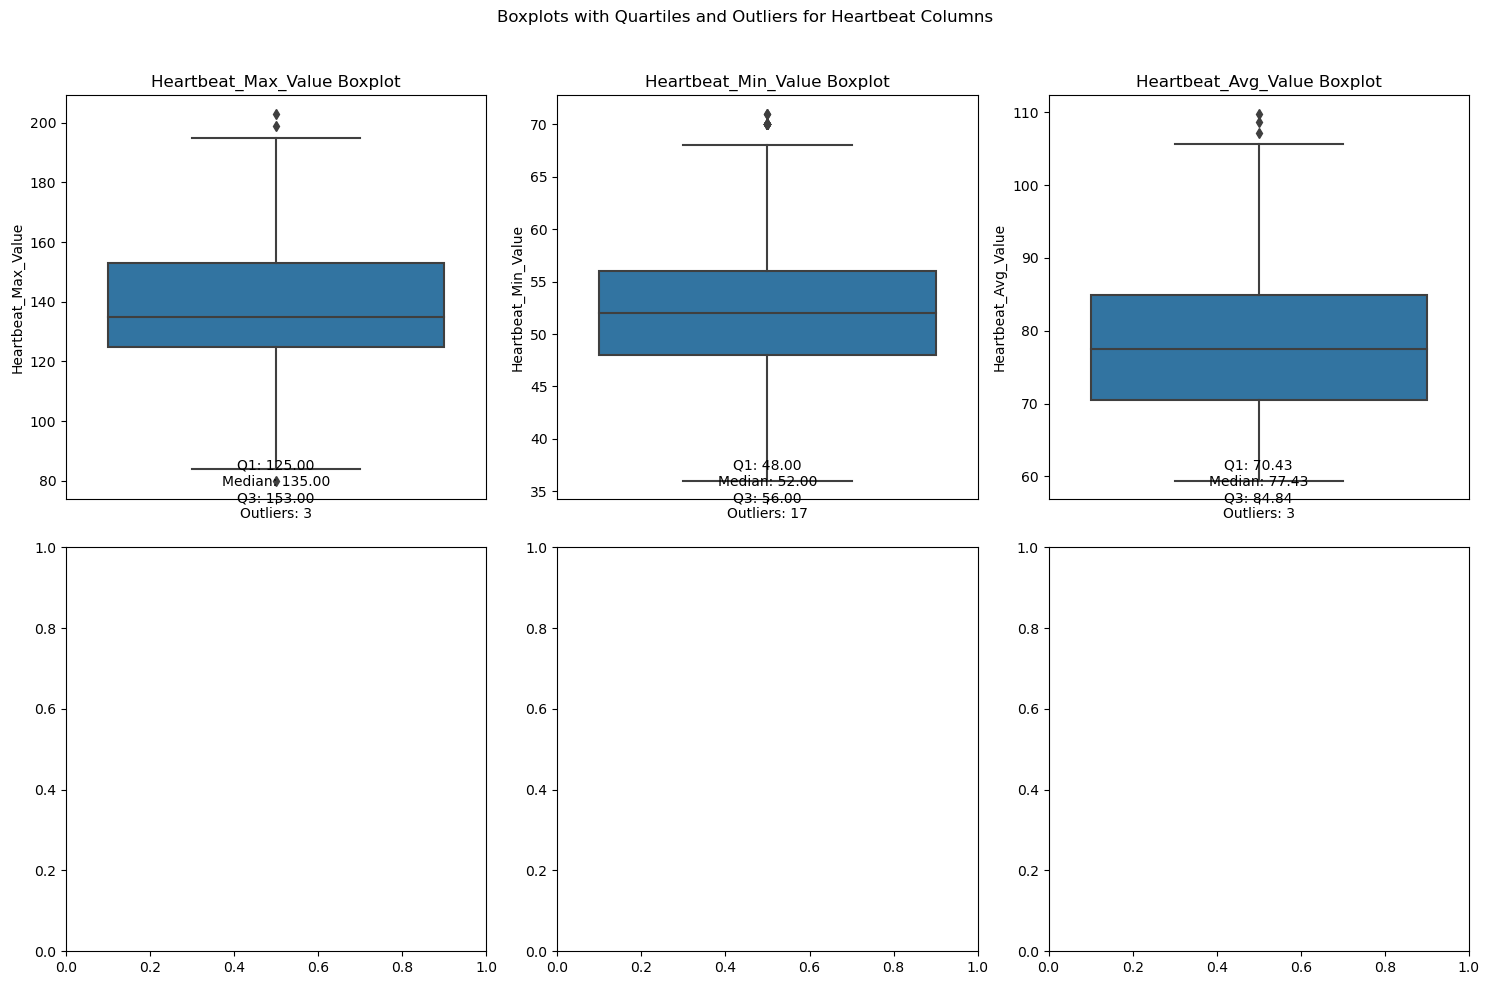

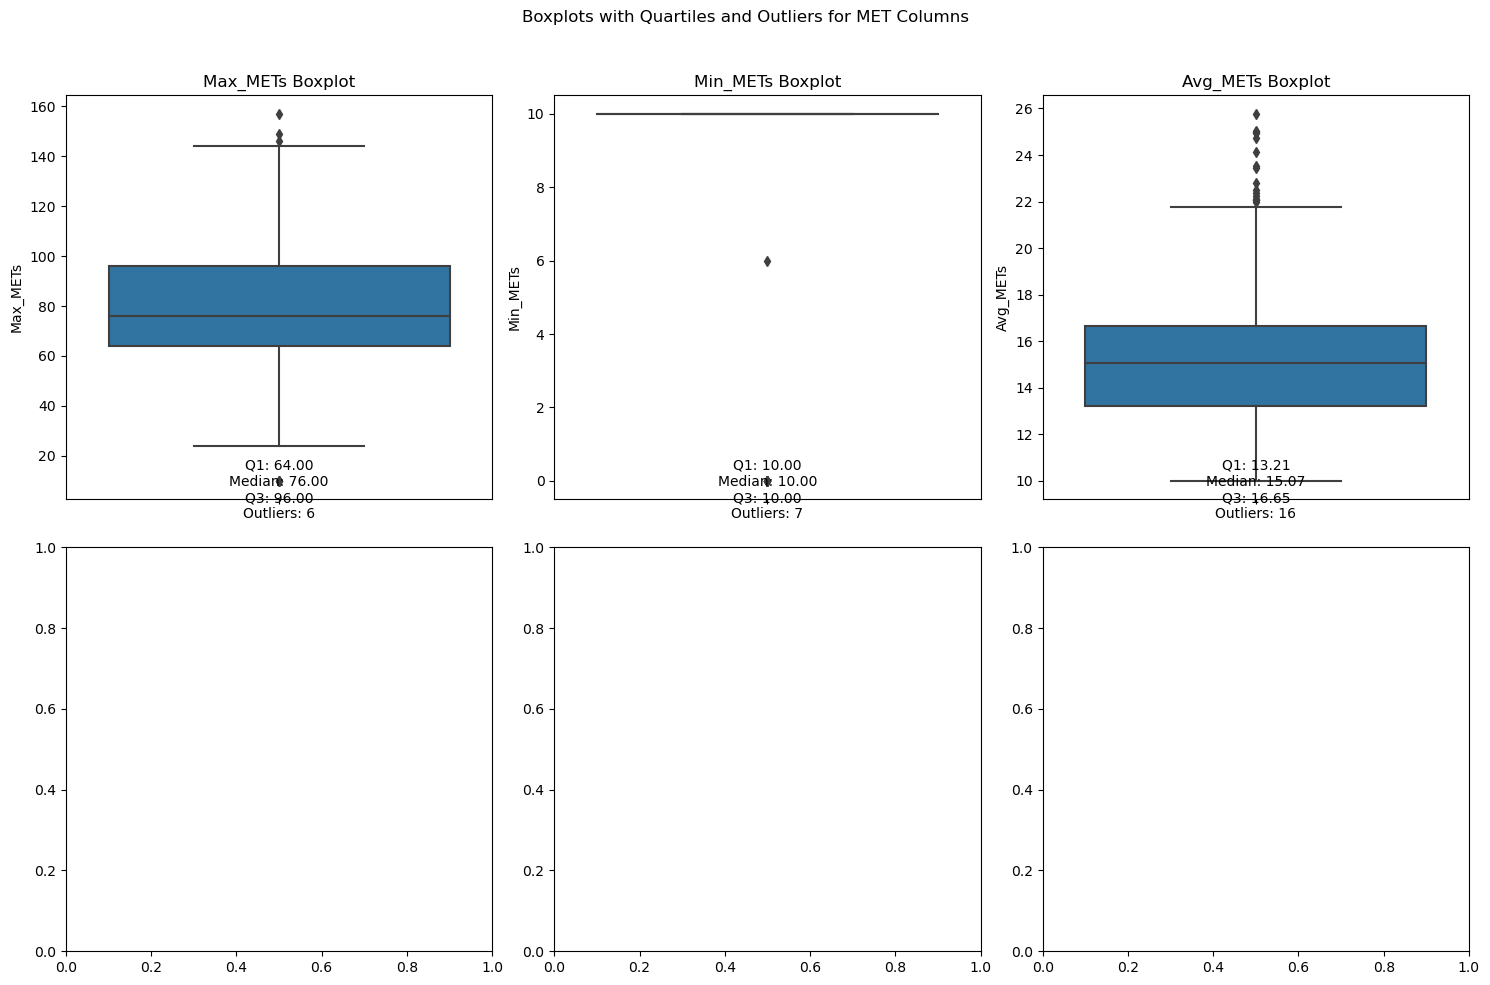

In [618]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot boxplots for a list of columns with quartile values and outliers
def plot_boxplots_with_quartiles_and_outliers(data, columns, group_name):
    num_columns = len(columns)
    fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(f'{col} Boxplot')
        axes[i].set_ylabel(col)
        
        # Calculate quartiles
        Q1 = data[col].quantile(0.25)
        Q2 = data[col].quantile(0.50)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
        
        # Display quartile values and outliers
        axes[i].text(0.5, 0.1, f'Q1: {Q1:.2f}\nMedian: {Q2:.2f}\nQ3: {Q3:.2f}\nOutliers: {len(outliers)}', 
                     transform=axes[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')
    
    plt.suptitle(f'Boxplots with Quartiles and Outliers for {group_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot boxplots with quartiles and outliers for each group
plot_boxplots_with_quartiles_and_outliers(all_merged_data, activity_columns, 'Activity Columns')
plot_boxplots_with_quartiles_and_outliers(all_merged_data, sleep_columns, 'Sleep Columns')
plot_boxplots_with_quartiles_and_outliers(all_merged_data, heartbeat_columns, 'Heartbeat Columns')
plot_boxplots_with_quartiles_and_outliers(all_merged_data, met_columns, 'MET Columns')


In [619]:
# Combine all columns into one list
all_columns = activity_columns + sleep_columns + heartbeat_columns + met_columns

# Create a DataFrame to store distribution results
distribution_results = []

# Function to determine distribution type and imputation method
def determine_distribution(data, column):
    valid_data = data[column].dropna()
    
    if len(valid_data) < 3:
        return 'Insufficient Data', None
    
    # Perform Shapiro-Wilk test for normality
    stat, p = shapiro(valid_data)
    if p > 0.05:
        return 'Normal', 'Mean'
    else:
        # Check skewness
        skewness = skew(valid_data)
        if skewness > 0.5:
            return 'Right-Skewed', 'Median'
        elif skewness < -0.5:
            return 'Left-Skewed', 'Median'
        else:
            # Check for symmetrical non-normal distributions using goodness-of-fit tests
            uniform_stat, uniform_p = kstest(valid_data, 'uniform', args=uniform.fit(valid_data))
            triang_stat, triang_p = kstest(valid_data, 'triang', args=triang.fit(valid_data))
            laplace_stat, laplace_p = kstest(valid_data, 'laplace', args=laplace.fit(valid_data))
            logistic_stat, logistic_p = kstest(valid_data, 'logistic', args=logistic.fit(valid_data))
            
            # Determine the best fitting distribution
            p_values = {
                'Uniform': uniform_p,
                'Triangular': triang_p,
                'Laplace': laplace_p,
                'Logistic': logistic_p
            }
            best_fit = max(p_values, key=p_values.get)
            
            if best_fit == 'Logistic':
                return best_fit, 'Mean'
            elif best_fit == 'Laplace':
                return best_fit, 'Median'
            elif p_values[best_fit] > 0.05:
                return best_fit, 'Mean or Median'
            else:
                return 'Symmetrical Non-Normal', 'Median'


# Analyze each column and store results
for column in all_columns:
    distribution_type, imputation_method = determine_distribution(all_merged_data, column)
    distribution_results.append({'Column': column, 'Distribution': distribution_type, 'Imputation Method': imputation_method})

# Create a DataFrame from the results
distribution_df = pd.DataFrame(distribution_results)

# Display the distribution DataFrame
print(distribution_df)




                      Column  Distribution Imputation Method
0                 TotalSteps  Right-Skewed            Median
1              TotalDistance  Right-Skewed            Median
2            TrackerDistance  Right-Skewed            Median
3         VeryActiveDistance  Right-Skewed            Median
4   ModeratelyActiveDistance  Right-Skewed            Median
5        LightActiveDistance      Logistic              Mean
6          VeryActiveMinutes  Right-Skewed            Median
7        FairlyActiveMinutes  Right-Skewed            Median
8       LightlyActiveMinutes      Logistic              Mean
9           SedentaryMinutes      Logistic              Mean
10                  Calories      Logistic              Mean
11         TotalSleepRecords  Right-Skewed            Median
12        TotalMinutesAsleep   Left-Skewed            Median
13            TotalTimeInBed       Laplace            Median
14       Heartbeat_Max_Value      Logistic              Mean
15       Heartbeat_Min_V

# IMPUTATION PHASE 1 ACTIVITY AND MET RECORDS COLUMNS

In [620]:
# Mean/Median Imputation: If the data is normally distributed, mean imputation might be suitable. 
# For skewed distributions, median imputation is often better.

# Combine all relevant columns for imputation
all_columns_imputation1 = activity_columns + met_columns

# Function to impute missing values based on distribution type
def impute_missing_values(data, column, distribution_type, group):
    if distribution_type in ['Normal', 'Logistic']:
        imputed_value = group[column].mean()
    elif distribution_type in ['Right-Skewed', 'Left-Skewed', 'Triangular', 'Laplace']:
        imputed_value = group[column].median()
    elif distribution_type == 'Uniform':
        imputed_value = (group[column].min() + group[column].max()) / 2
    else:
        imputed_value = group[column].median()  # Default to median for symmetrical non-normal
    # Fill missing values in the original DataFrame
    data.loc[group.index, column] = group[column].fillna(imputed_value)

# Create a DataFrame to store the results
distribution_df_imputation1 = pd.DataFrame(columns=['Column', 'Distribution', 'Imputation Status'])

# Analyze each column and impute missing values
for column in all_columns_imputation1:
    distribution_type = determine_distribution(all_merged_data, column)
    for Id, group in all_merged_data.groupby('Id'):
        impute_missing_values(all_merged_data, column, distribution_type, group)
    # Append to distribution_df_imputation1 after processing all groups for the column using pandas.concat
    distribution_df_imputation1 = pd.concat([
        distribution_df_imputation1,
        pd.DataFrame({'Column': [column], 'Distribution': [distribution_type], 'Imputation Status': ['Completed']})
    ], ignore_index=True)

# Save the imputed dataset to a new DataFrame
all_merged_data_withactivityimputed = all_merged_data.copy()

# Check for missing data in each group
all_merged_data_imputed1 = all_merged_data_withactivityimputed.copy()
all_merged_data_imputed1['Activity_Record_Missing'] = all_merged_data_imputed1[activity_columns].isnull().any(axis=1)
all_merged_data_imputed1['Sleep_Record_Missing'] = all_merged_data_imputed1[sleep_columns].isnull().any(axis=1)
all_merged_data_imputed1['Heartbeat_Record_Missing'] = all_merged_data_imputed1[heartbeat_columns].isnull().any(axis=1)
all_merged_data_imputed1['Met_Record_Missing'] = all_merged_data_imputed1[met_columns].isnull().any(axis=1)

# Calculate missing counts for each user
missing_counts_imputed1 = all_merged_data_imputed1.groupby('Id').agg(
    Total_Records=('Id', 'size'),
    Activity_Record_Missing=('Activity_Record_Missing', 'sum'),
    Sleep_Record_Missing=('Sleep_Record_Missing', 'sum'),
    Heartbeat_Record_Missing=('Heartbeat_Record_Missing', 'sum'),
    Met_Record_Missing=('Met_Record_Missing', 'sum')
).reset_index()

# Display the distribution DataFrame and check for missing values
print(distribution_df_imputation1)
print(missing_counts_imputed1)

# Save the DataFrame to an Excel file
excel_file_path = 'all_merged_data_imputation1.xlsx'
all_merged_data_withactivityimputed.to_excel(excel_file_path, index=False)
print(f"File saved as {excel_file_path}")




                      Column            Distribution Imputation Status
0                 TotalSteps  (Right-Skewed, Median)         Completed
1              TotalDistance  (Right-Skewed, Median)         Completed
2            TrackerDistance  (Right-Skewed, Median)         Completed
3         VeryActiveDistance  (Right-Skewed, Median)         Completed
4   ModeratelyActiveDistance  (Right-Skewed, Median)         Completed
5        LightActiveDistance        (Logistic, Mean)         Completed
6          VeryActiveMinutes  (Right-Skewed, Median)         Completed
7        FairlyActiveMinutes  (Right-Skewed, Median)         Completed
8       LightlyActiveMinutes        (Logistic, Mean)         Completed
9           SedentaryMinutes        (Logistic, Mean)         Completed
10                  Calories        (Logistic, Mean)         Completed
11                  Max_METs        (Logistic, Mean)         Completed
12                  Min_METs   (Left-Skewed, Median)         Completed
13    

# IMPUTATION PHASE 2 SLEEP AND HEARBEAT RECORDS COLUMNS

In [621]:
# Step 1: Create a list to store the IDs of the imputed records
imputed_ids = []

# Combine sleep and heartbeat columns
sleep_heartbeat_columns = sleep_columns + heartbeat_columns

# Step 2: Loop through the missing counts to identify IDs for imputation
for _, row in missing_counts_imputed1.iterrows():
    id_value = row['Id']
    sleep_missing = int(row['Sleep_Record_Missing'])
    heartbeat_missing = int(row['Heartbeat_Record_Missing'])
    
    # Check conditions for imputation
    if sleep_missing <= 10 or heartbeat_missing <= 10:
        # Perform imputation for combined sleep and heartbeat columns
        for column in sleep_heartbeat_columns:
            # Get the distribution type
            distribution_type_row = distribution_df.loc[distribution_df['Column'] == column]
            
            if not distribution_type_row.empty:
                distribution_type = distribution_type_row['Distribution'].values[0]  # Get the first value
                
                # Check if the ID has any missing value in the current column
                if all_merged_data_withactivityimputed.loc[all_merged_data_withactivityimputed['Id'] == id_value, column].isnull().any():
                    # Perform the imputation
                    impute_missing_values(
                        all_merged_data_withactivityimputed,
                        column,
                        distribution_type,
                        all_merged_data_withactivityimputed[all_merged_data_withactivityimputed['Id'] == id_value]
                    )
        # Store the ID of the imputed records
        imputed_ids.append(id_value)

# Create a new DataFrame to hold the final results
all_merged_data_imputed2 = all_merged_data_withactivityimputed.copy()

# Save the DataFrame to an Excel file
excel_file_path = 'all_merged_data_imputation2.xlsx'
all_merged_data_imputed2.to_excel(excel_file_path, index=False)
print(f"File saved as {excel_file_path}")

# Check for missing data in each group
all_merged_data_imputed2['Activity_Record_Missing'] = all_merged_data_imputed2[activity_columns].isnull().any(axis=1)
all_merged_data_imputed2['Sleep_Record_Missing'] = all_merged_data_imputed2[sleep_columns].isnull().any(axis=1)
all_merged_data_imputed2['Heartbeat_Record_Missing'] = all_merged_data_imputed2[heartbeat_columns].isnull().any(axis=1)
all_merged_data_imputed2['met_Record_Missing'] = all_merged_data_imputed2[met_columns].isnull().any(axis=1)

missing_counts_imputed2 = all_merged_data_imputed2.groupby('Id').agg(
    Total_Records=('Id', 'size'),
    Activity_Record_Missing=('Activity_Record_Missing', 'sum'),
    Sleep_Record_Missing=('Sleep_Record_Missing', 'sum'),
    Heartbeat_Record_Missing=('Heartbeat_Record_Missing', 'sum'),
    met_Record_Missing=('met_Record_Missing', 'sum')
).reset_index()

print(missing_counts_imputed2)


File saved as all_merged_data_imputation2.xlsx
            Id  Total_Records  Activity_Record_Missing  Sleep_Record_Missing  Heartbeat_Record_Missing  met_Record_Missing
0   1503960366             30                        0                     0                        30                   0
1   1624580081             31                        0                    31                        31                   0
2   1644430081             30                        0                    26                        30                   0
3   1844505072             22                        0                    19                        22                   0
4   1927972279             18                        0                    13                        18                   0
5   2022484408             31                        0                    31                         0                   0
6   2026352035             31                        0                     0                

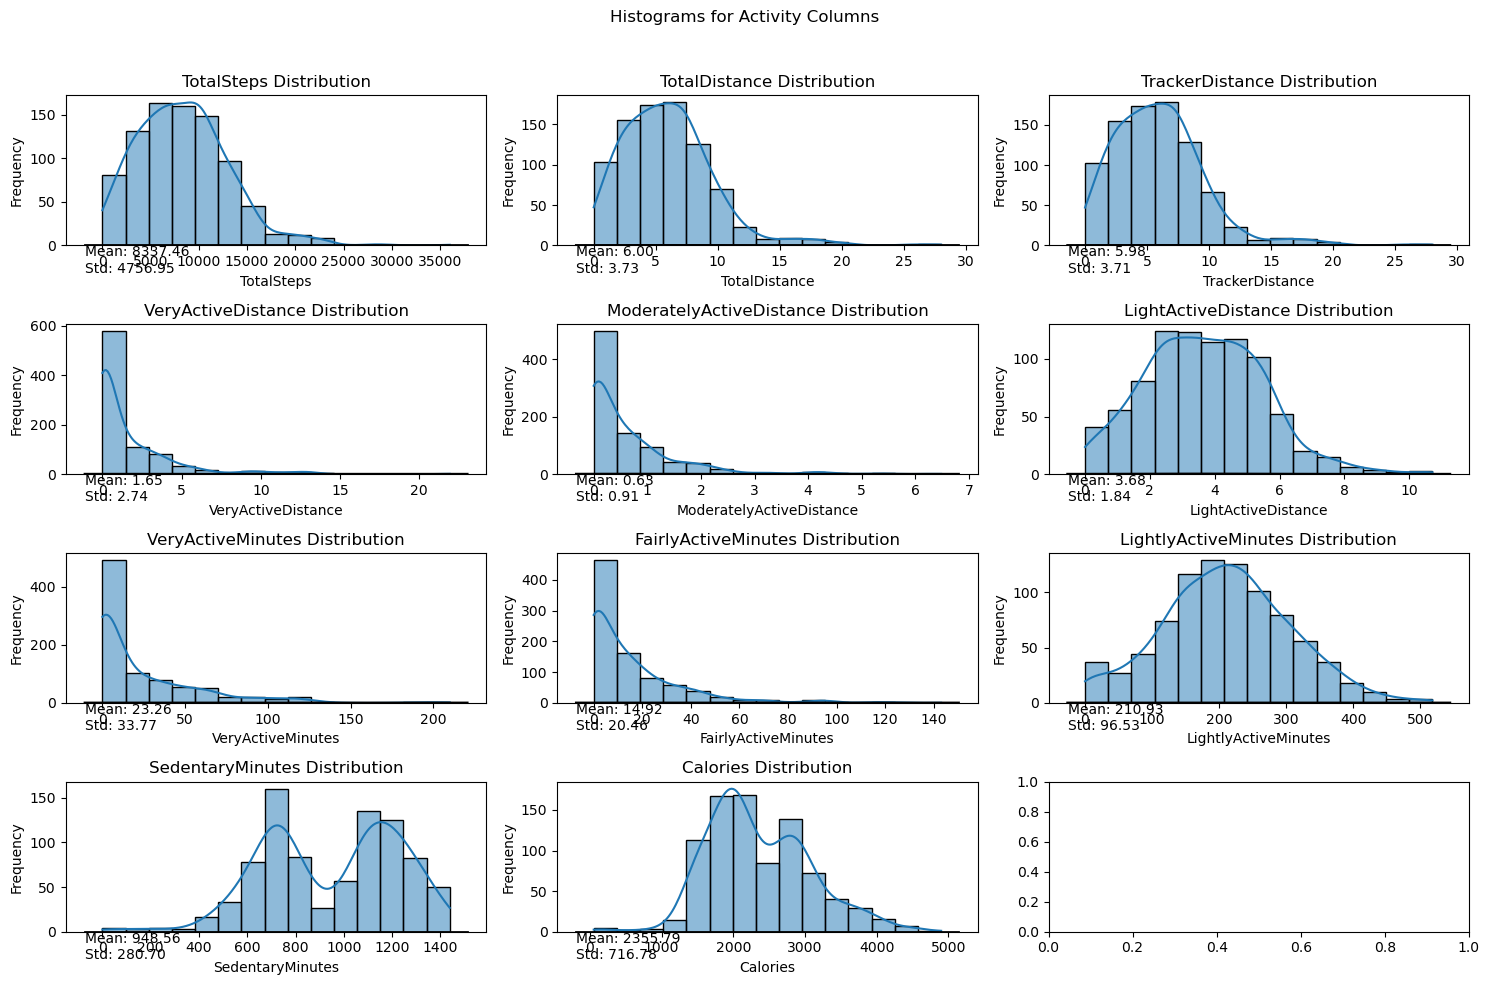

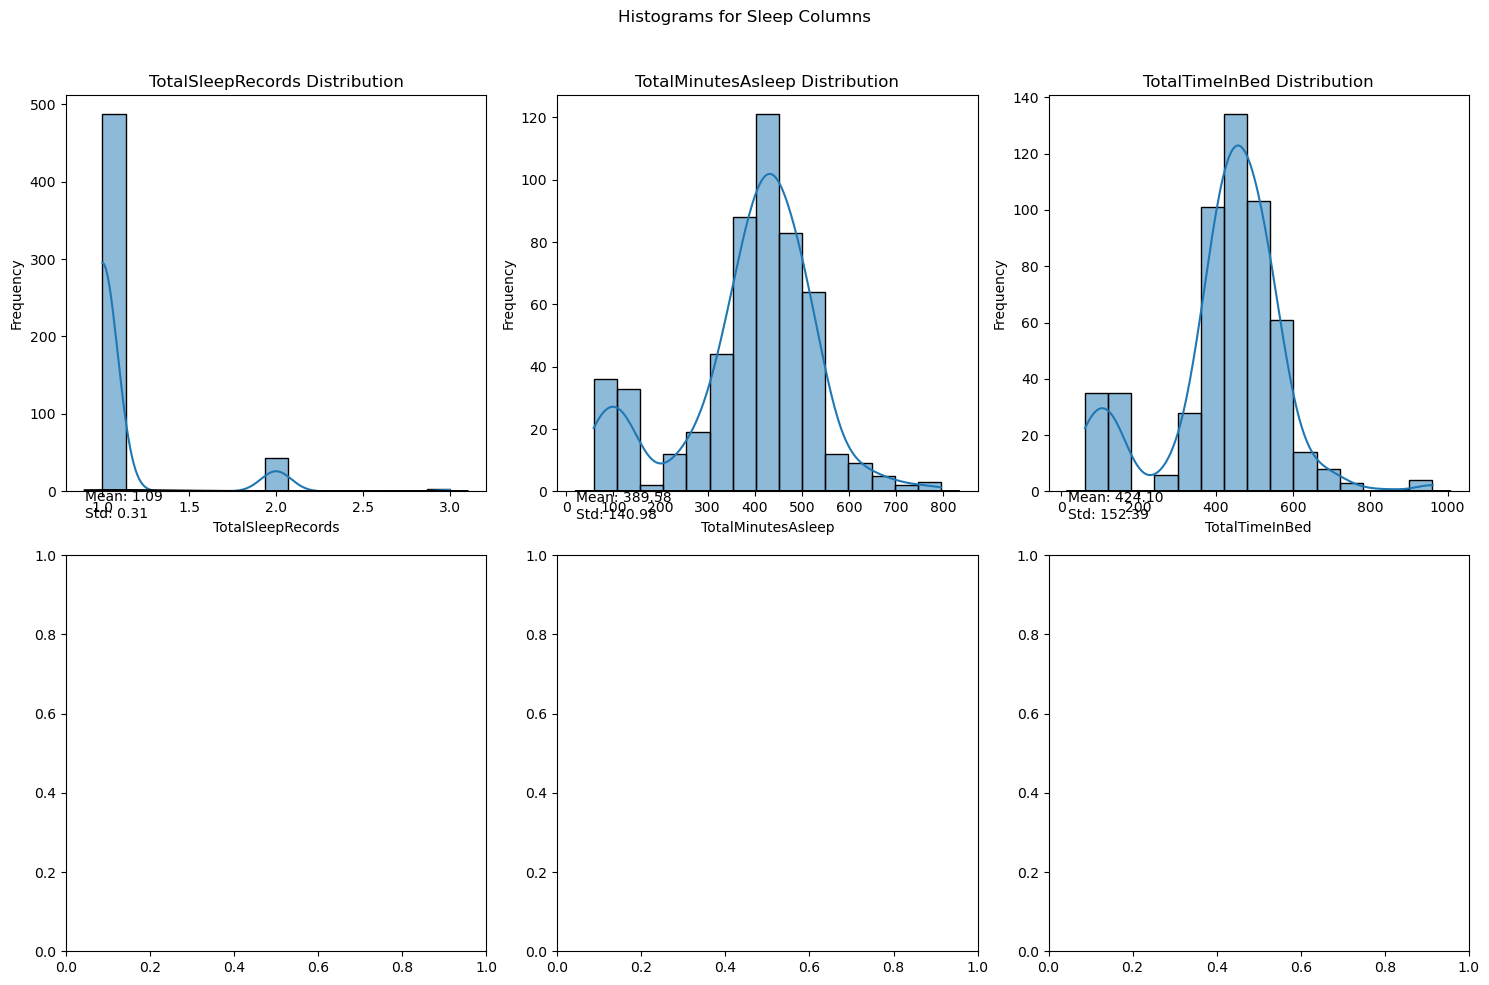

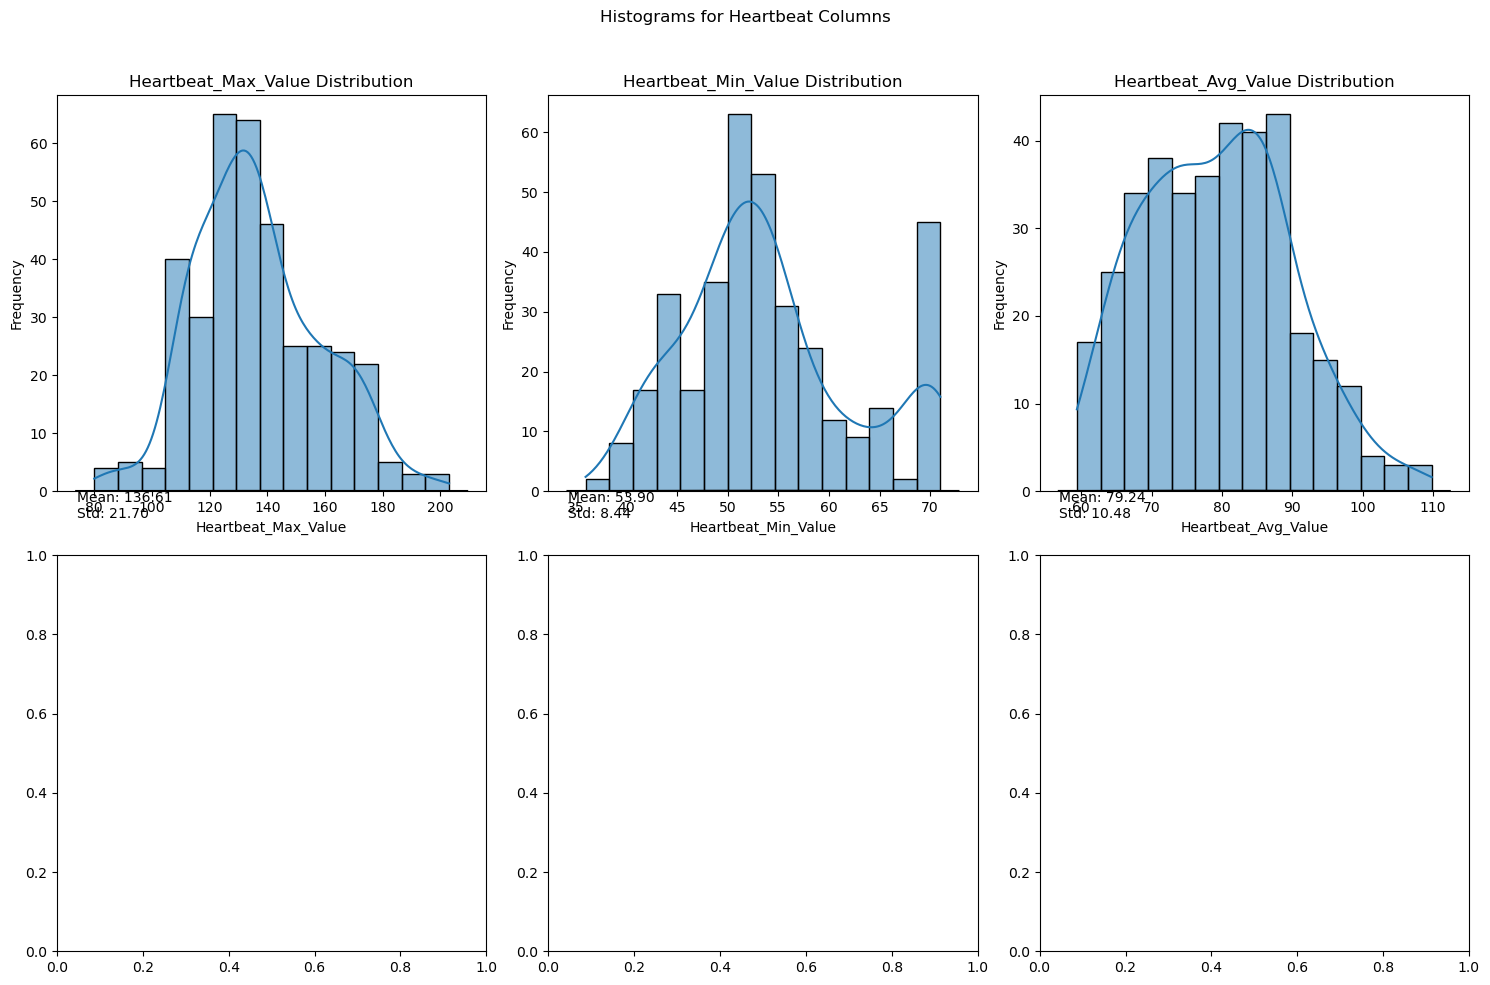

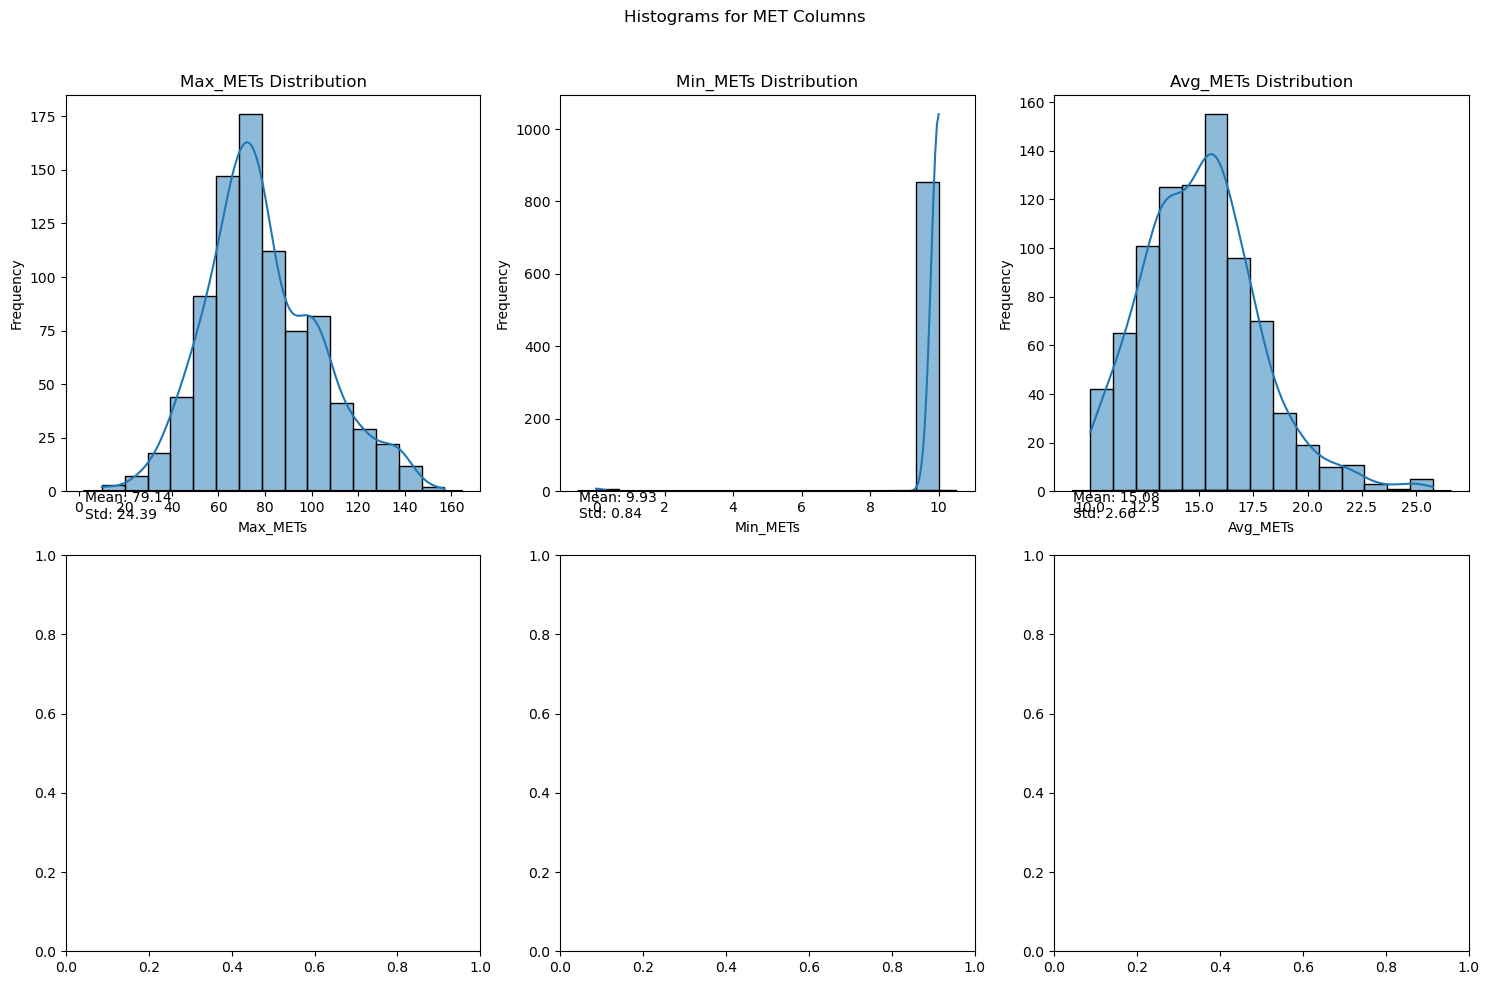

In [622]:
# Plot histograms for each group
plot_histograms(all_merged_data_imputed2, activity_columns, 'Activity Columns')
plot_histograms(all_merged_data_imputed2, sleep_columns, 'Sleep Columns')
plot_histograms(all_merged_data_imputed2, heartbeat_columns, 'Heartbeat Columns')
plot_histograms(all_merged_data_imputed2, met_columns, 'MET Columns')

# ACTIVITY LEVEL TO PREDICT HEARBEAT RECORDS COLUMNS
## Feature Selection Technique
### Start with correlation analysis to identify initial relevant features. Apply stepwise regression or RFE to refine the feature set.Validate the selected features using cross-validation.

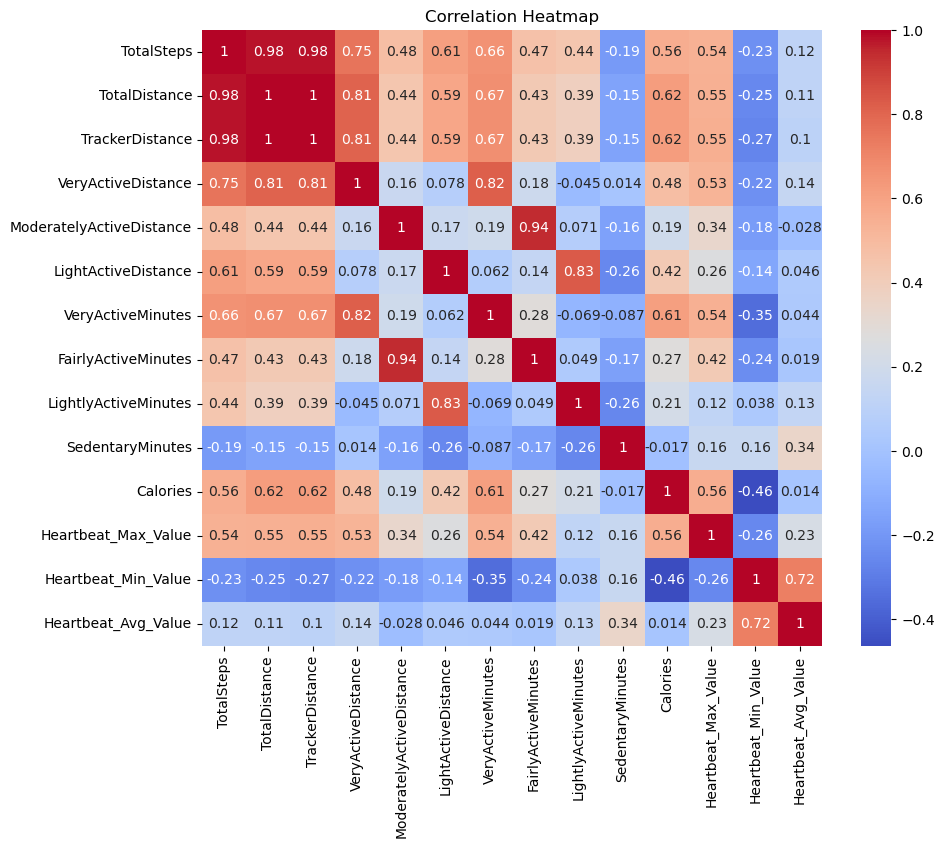

In [623]:
# Calculate correlation coefficients for activity and heartbeat columns
correlation_matrix = all_merged_data_imputed2[activity_columns + heartbeat_columns].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)  
plt.title('Correlation Heatmap') 
plt.show()  


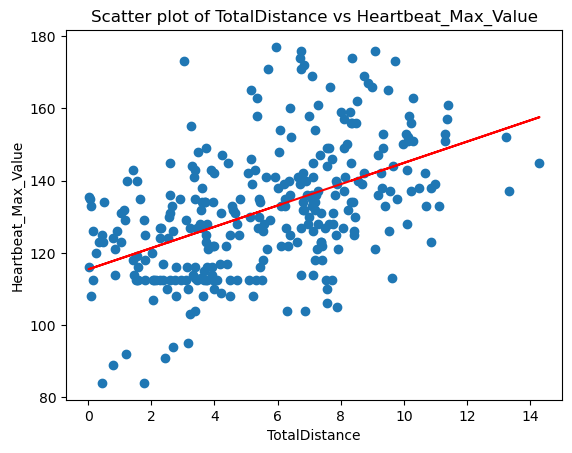

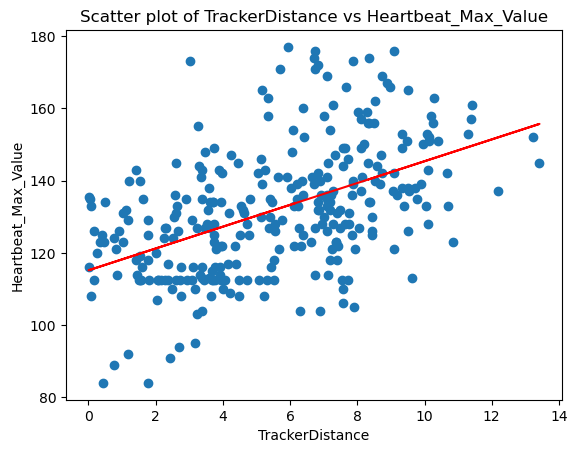

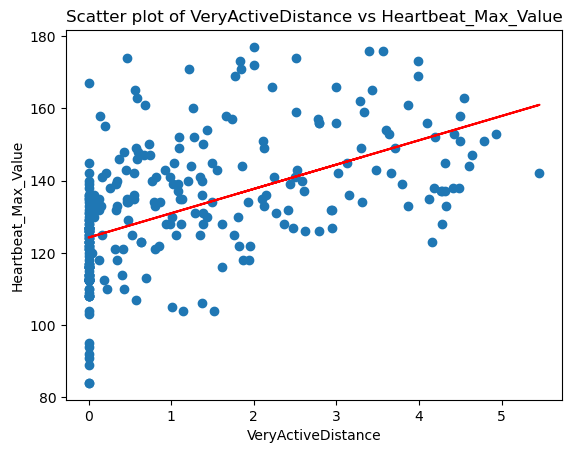

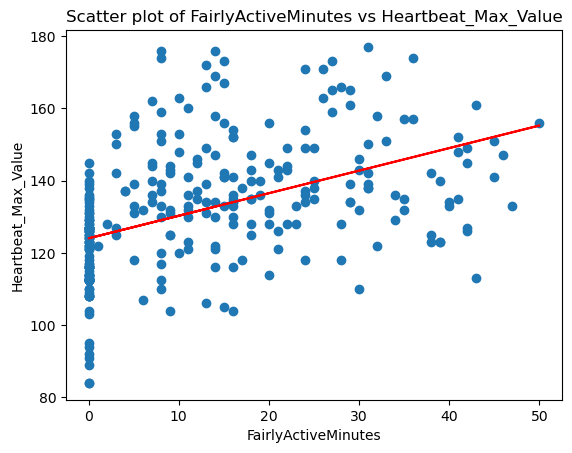

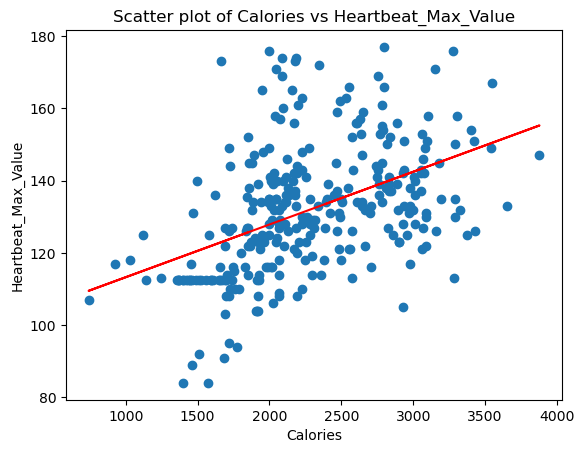

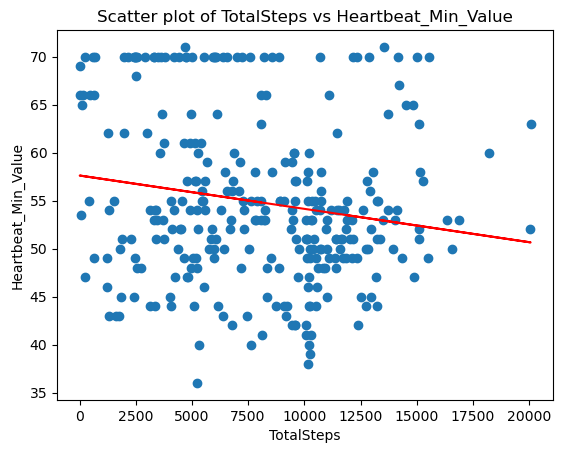

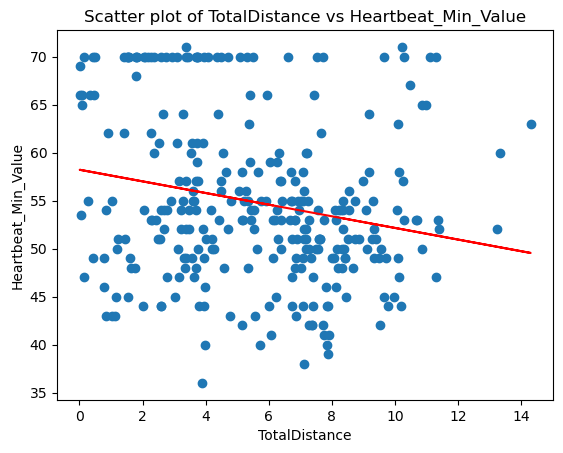

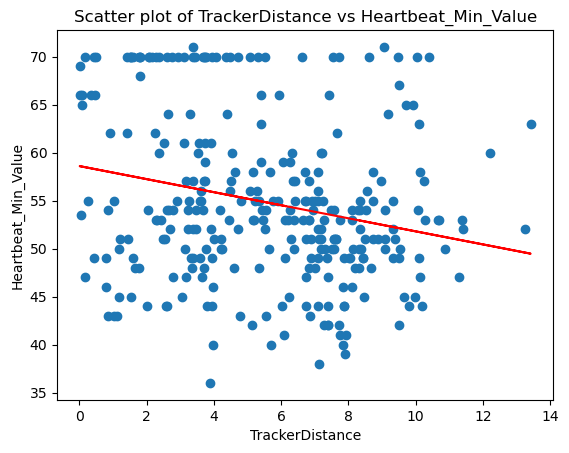

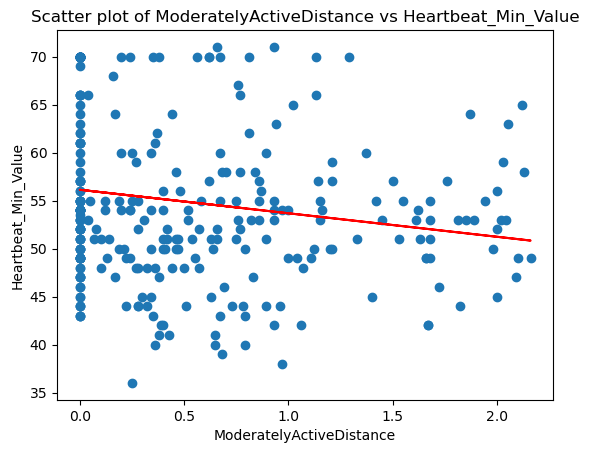

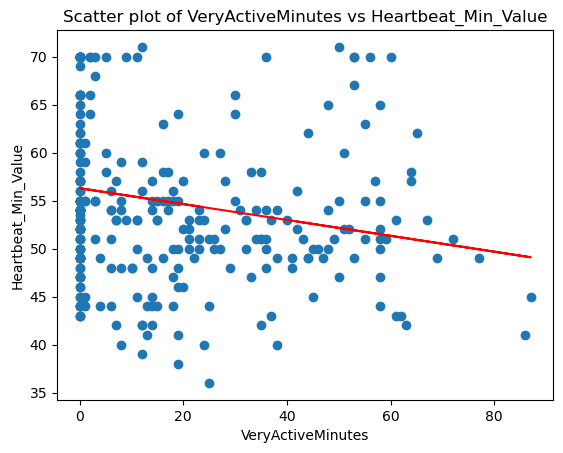

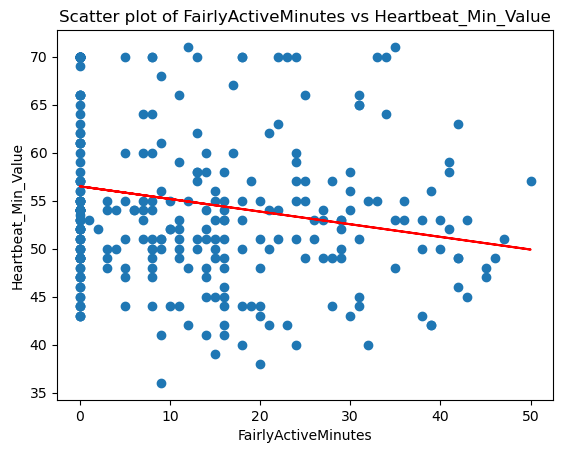

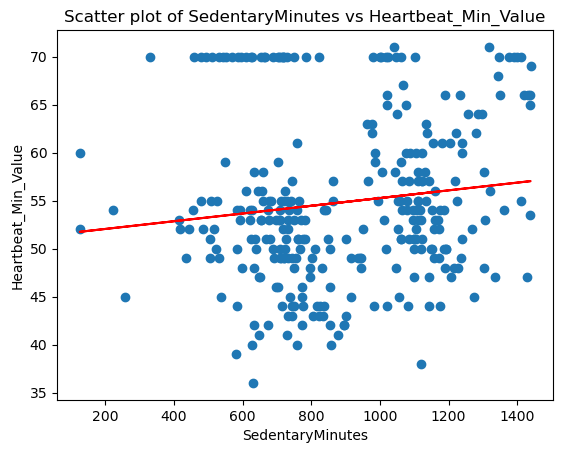

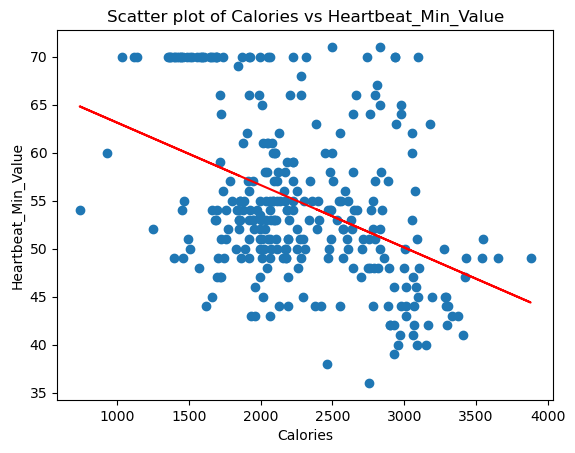

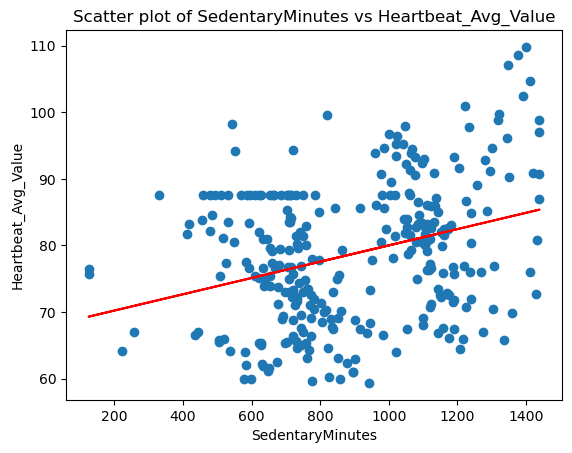

All Features DataFrame:
                 Target                   Feature  Correlation       P-Value  Selected
0   Heartbeat_Max_Value                TotalSteps     0.539185  4.753849e-19     False
1   Heartbeat_Max_Value             TotalDistance     0.547536  3.474803e-20      True
2   Heartbeat_Max_Value           TrackerDistance     0.548725  2.998741e-20      True
3   Heartbeat_Max_Value        VeryActiveDistance     0.529881  3.742913e-24      True
4   Heartbeat_Max_Value  ModeratelyActiveDistance     0.335583  1.446577e-14     False
5   Heartbeat_Max_Value       LightActiveDistance     0.261379  1.913206e-05     False
6   Heartbeat_Max_Value         VeryActiveMinutes     0.544453  1.890327e-25     False
7   Heartbeat_Max_Value       FairlyActiveMinutes     0.416696  1.061614e-17      True
8   Heartbeat_Max_Value      LightlyActiveMinutes     0.123149  3.146418e-02     False
9   Heartbeat_Max_Value          SedentaryMinutes     0.158948  2.738605e-03     False
10  Heartbeat_Max_V

In [624]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Exclude rows with missing values in heartbeat_columns
all_merged_data_imputed2_cleaned = all_merged_data_imputed2.dropna(subset=heartbeat_columns)

# Remove outliers from activity_columns and heartbeat_columns
for column in activity_columns + heartbeat_columns:
    all_merged_data_imputed2_cleaned = remove_outliers_iqr(all_merged_data_imputed2_cleaned, column)

# Initialize lists to store feature details for each target
results_list = []
selected_features_list = []

# Perform stepwise regression for each target
for target in heartbeat_columns:
    feature_details = {}

    # Forward Selection
    for feature in activity_columns:
        model = sm.OLS(all_merged_data_imputed2_cleaned[target], sm.add_constant(all_merged_data_imputed2_cleaned[[feature]]))
        results = model.fit()
        p_value = results.pvalues[feature]
        correlation = correlation_matrix.loc[target, feature]
        feature_details[feature] = {'p_value': p_value, 'correlation': correlation, 'selected': p_value < 0.05}

    # Backward Elimination
    selected_features = [feature for feature, details in feature_details.items() if details['selected']]
    while True:
        model = sm.OLS(all_merged_data_imputed2_cleaned[target], sm.add_constant(all_merged_data_imputed2_cleaned[selected_features]))
        results = model.fit()
        p_values = results.pvalues[1:]  # Exclude the constant term
        if p_values.max() > 0.05:  # significance level (Alpha)
            least_significant_feature = p_values.idxmax()
            selected_features.remove(least_significant_feature)
            feature_details[least_significant_feature]['selected'] = False
        else:
            break

    # Store feature details for this target in the results list
    for feature, details in feature_details.items():
        results_list.append({
            'Target': target,
            'Feature': feature,
            'Correlation': details['correlation'],
            'P-Value': details['p_value'],
            'Selected': details['selected']
        })
        if details['selected']:
            selected_features_list.append({
                'Target': target,
                'Feature': feature,
                'Correlation': details['correlation'],
                'P-Value': details['p_value']
            })

            # Scatter Plot with Line of Best Fit for Selected Features
            plt.scatter(all_merged_data_imputed2_cleaned[feature], all_merged_data_imputed2_cleaned[target])
            
            # Calculate line of best fit
            x = all_merged_data_imputed2_cleaned[feature]
            y = all_merged_data_imputed2_cleaned[target]
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, m*x + b, color='red')  # Line of best fit
            
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.title(f'Scatter plot of {feature} vs {target}')
            plt.show()

# Convert the results lists to DataFrames
results_df = pd.DataFrame(results_list)
selected_features_df = pd.DataFrame(selected_features_list)

# Display the DataFrames
print("All Features DataFrame:")
print(results_df)
print("\nSelected Features DataFrame:")
print(selected_features_df)

    
# In hypothesis testing, we start with a null hypothesis (usually stating no effect or no relationship) 
# and an alternative hypothesis (stating an effect or relationship). The p-value quantifies the probability 
# of observing the data (or more extreme data) under the assumption that the null hypothesis is true.

#The significance level (often denoted as α) is the threshold below which we consider a p-value statistically significant.

#Correlation Coefficient: This measures the strength and direction of the linear relationship between two variables. A higher absolute value indicates a stronger relationship.
#P-Value: This measures the statistical significance of the relationship. A lower p-value indicates that the observed relationship is less likely to be due to random chance.
#IN THIS CASE WE USED THE P-VALUE, because Useful for hypothesis testing and determining whether to include a variable in a model. 

## SIMPLE LINEAR REGRESSION 

In [625]:
#fit_intercept: Whether to calculate the intercept for this model. Default is True.
#positive: When set to True, forces the coefficients to be positive. Default is False1.

# Define the parameter grid without the deprecated 'normalize' parameter
param_grid_linear = {
    'fit_intercept': [True, False],
}

# Initialize the Linear Regression model
linear_regression = LinearRegression()

# Initialize GridSearchCV with error_score='raise'
grid_search = GridSearchCV(estimator=linear_regression, param_grid=param_grid_linear, cv=5, scoring='neg_mean_squared_error', error_score='raise')

# Initialize lists to store the results
model_results = []
coefficients_results = []

# Perform model training and evaluation for each target
for target in heartbeat_columns:
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit GridSearchCV
    try:
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_  # Convert back to positive MSE
        
        # Train the model with the best parameters
        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calculate errors
        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)
        
        # Extract coefficients
        coefficients = best_model.coef_
        
        # Store the model results
        model_results.append({
            'Target': target,
            'Best Parameters': best_params,
            'Train Error (MSE)': train_error,
            'Test Error (MSE)': test_error,
            'Training Size': len(X_train),
            'Testing Size': len(X_test)
        })
        
        # Store the coefficients results
        for feature, coef in zip(selected_features, coefficients):
            coefficients_results.append({
                'Target': target,
                'Feature': feature,
                'Coefficient': coef
            })
    
    except ValueError as e:
        print(f"Error for target {target}: {e}")
    except AttributeError as e:
        print(f"Error for target {target}: {e}")

# Convert the results list to DataFrames
model_results_df = pd.DataFrame(model_results)
coefficients_simple = pd.DataFrame(coefficients_results)

# Set display options to avoid truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 500)

# Display the DataFrames in a more organized format
print("Model Results:")
print(model_results_df.to_string(index=False))
print("\nCoefficients:")
print(coefficients_simple.to_string(index=False))




Model Results:
             Target         Best Parameters  Train Error (MSE)  Test Error (MSE)  Training Size  Testing Size
Heartbeat_Max_Value {'fit_intercept': True}         189.774064        213.052067            241            61
Heartbeat_Min_Value {'fit_intercept': True}          45.076464         36.107885            241            61
Heartbeat_Avg_Value {'fit_intercept': True}         102.867623         76.774063            241            61

Coefficients:
             Target                  Feature  Coefficient
Heartbeat_Max_Value            TotalDistance    -4.635534
Heartbeat_Max_Value          TrackerDistance     4.674983
Heartbeat_Max_Value       VeryActiveDistance     4.538550
Heartbeat_Max_Value      FairlyActiveMinutes     0.333224
Heartbeat_Max_Value                 Calories     0.006051
Heartbeat_Min_Value               TotalSteps     0.004289
Heartbeat_Min_Value            TotalDistance    10.583945
Heartbeat_Min_Value          TrackerDistance   -16.030291
Heartbea

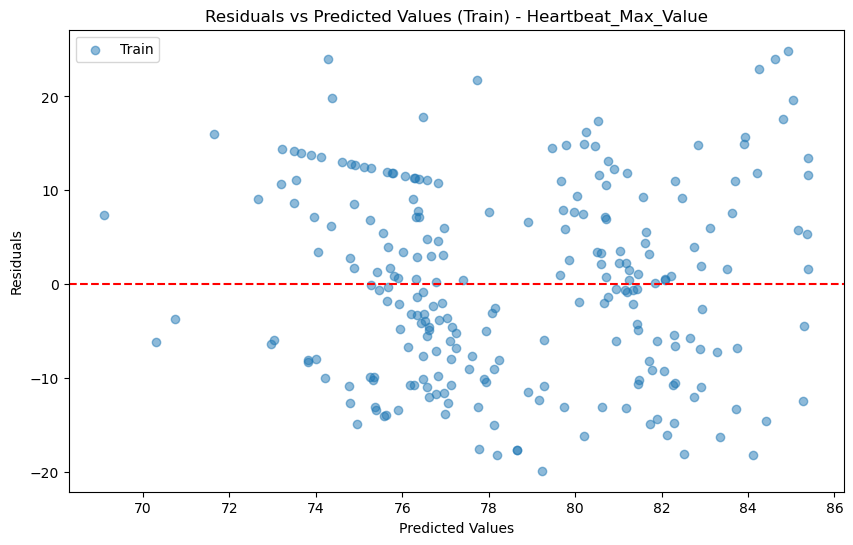

Interpretation for Residuals vs Predicted Values (Train) - Heartbeat_Max_Value:
If the residuals are randomly scattered around the horizontal axis (y=0), it suggests that the model's predictions are unbiased.
Patterns or trends in the residuals might indicate issues such as non-linearity, heteroscedasticity, or outliers.



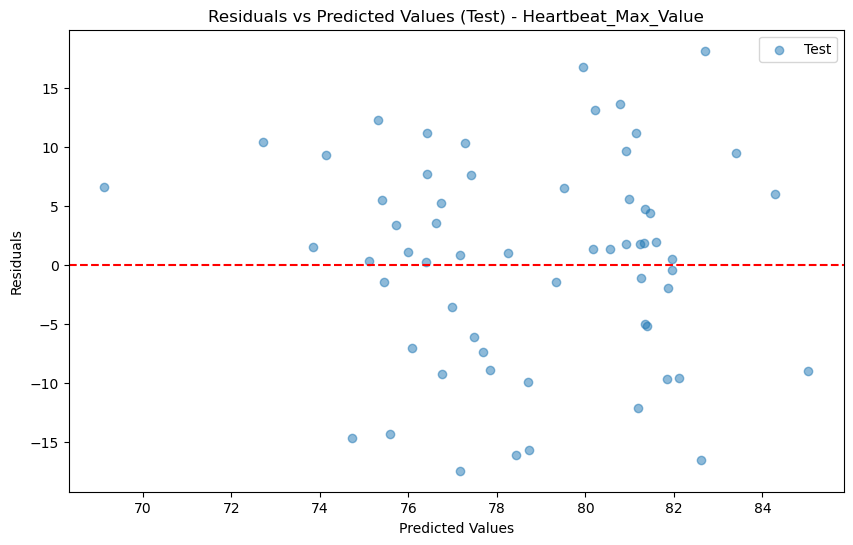

Interpretation for Residuals vs Predicted Values (Test) - Heartbeat_Max_Value:
Similar to the training residuals, random scatter around the horizontal axis indicates good model performance.
Any patterns or trends might suggest that the model is not capturing some aspects of the data.



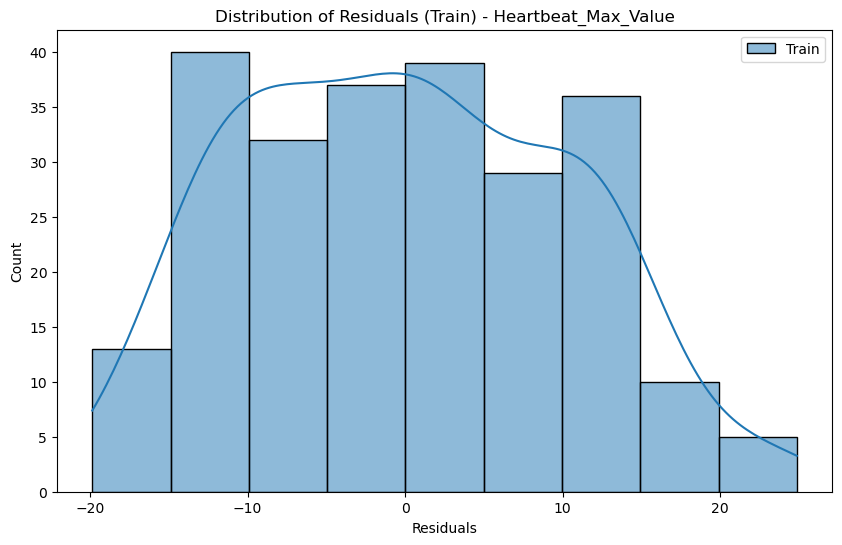

Interpretation for Distribution of Residuals (Train) - Heartbeat_Max_Value:
A normal distribution of residuals centered around zero suggests that the model's errors are normally distributed.
Skewness or kurtosis in the distribution might indicate issues with the model or data.



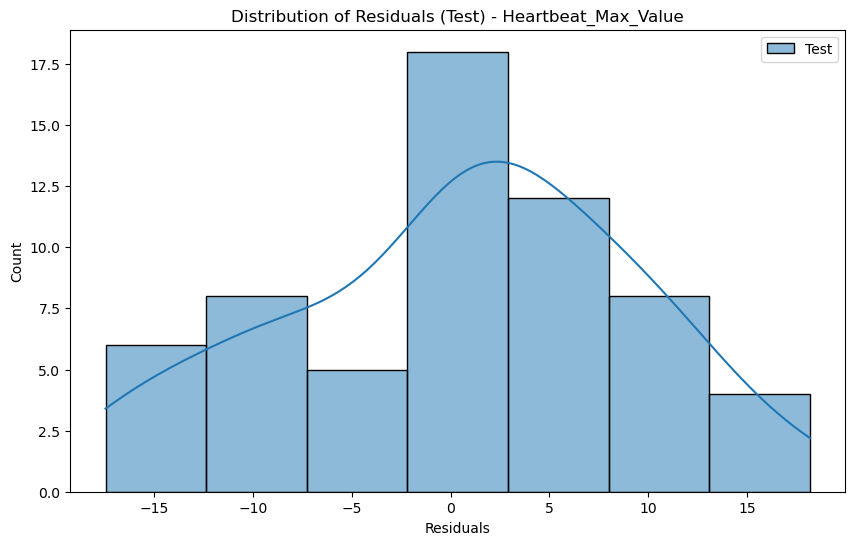

Interpretation for Distribution of Residuals (Test) - Heartbeat_Max_Value:
A normal distribution of residuals centered around zero for the test set also suggests good model performance.
Deviations from normality might indicate that the model is not capturing all patterns in the data.



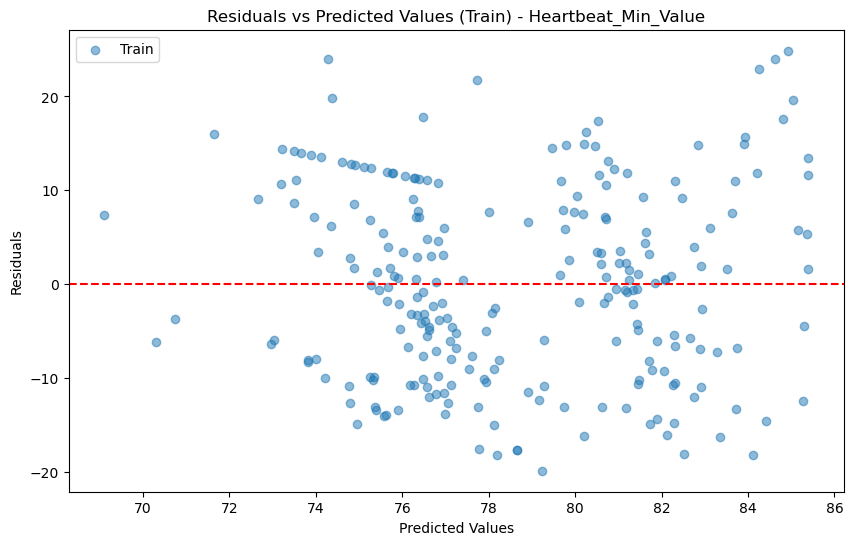

Interpretation for Residuals vs Predicted Values (Train) - Heartbeat_Min_Value:
If the residuals are randomly scattered around the horizontal axis (y=0), it suggests that the model's predictions are unbiased.
Patterns or trends in the residuals might indicate issues such as non-linearity, heteroscedasticity, or outliers.



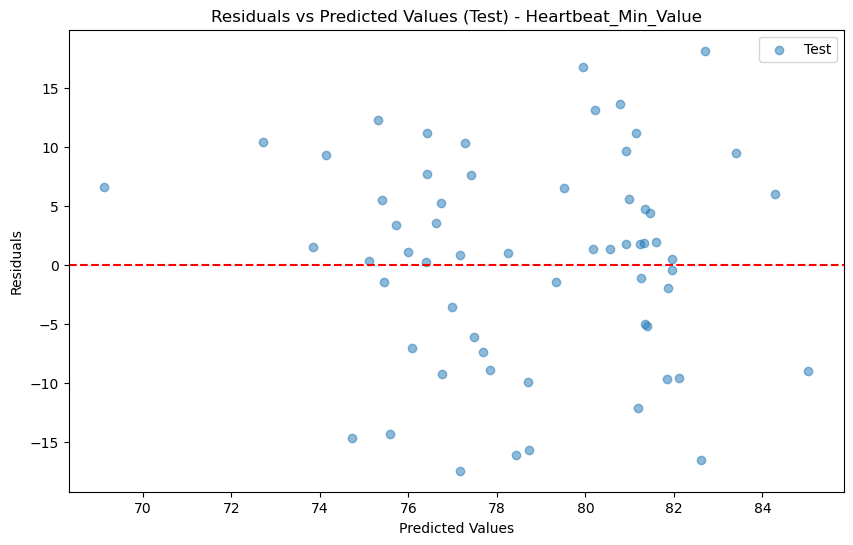

Interpretation for Residuals vs Predicted Values (Test) - Heartbeat_Min_Value:
Similar to the training residuals, random scatter around the horizontal axis indicates good model performance.
Any patterns or trends might suggest that the model is not capturing some aspects of the data.



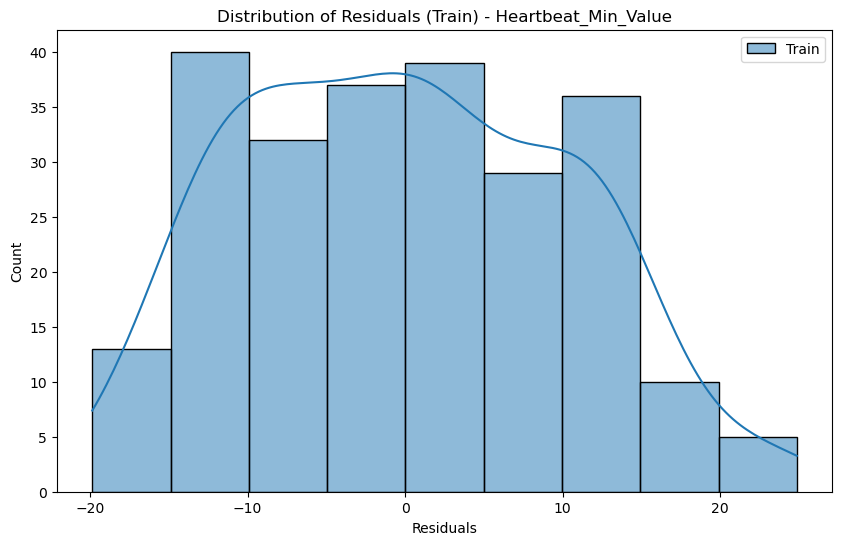

Interpretation for Distribution of Residuals (Train) - Heartbeat_Min_Value:
A normal distribution of residuals centered around zero suggests that the model's errors are normally distributed.
Skewness or kurtosis in the distribution might indicate issues with the model or data.



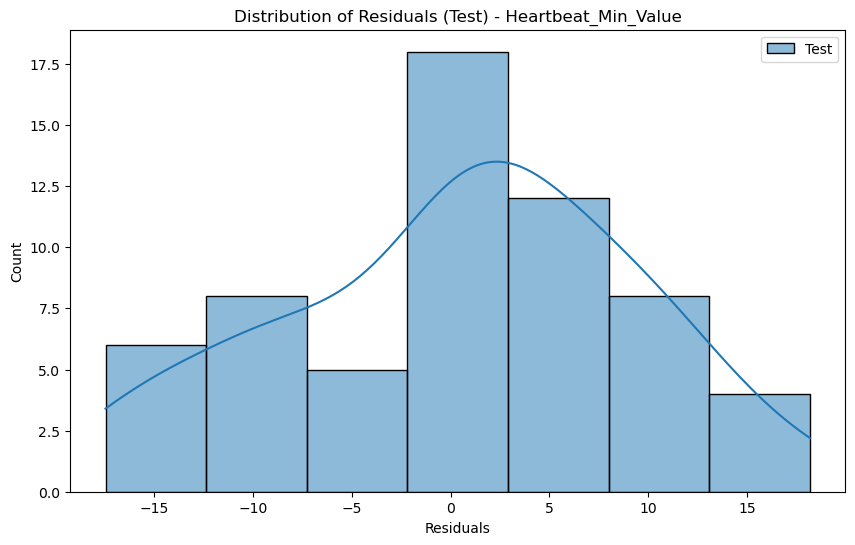

Interpretation for Distribution of Residuals (Test) - Heartbeat_Min_Value:
A normal distribution of residuals centered around zero for the test set also suggests good model performance.
Deviations from normality might indicate that the model is not capturing all patterns in the data.



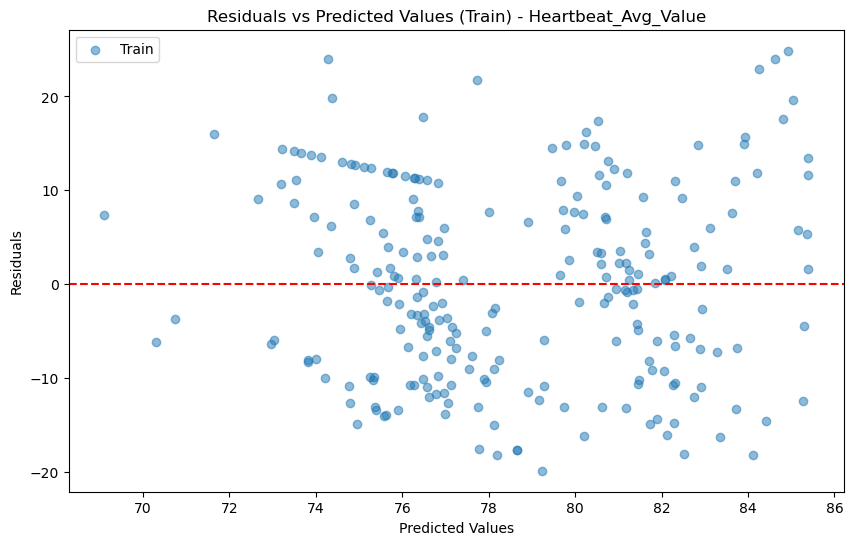

Interpretation for Residuals vs Predicted Values (Train) - Heartbeat_Avg_Value:
If the residuals are randomly scattered around the horizontal axis (y=0), it suggests that the model's predictions are unbiased.
Patterns or trends in the residuals might indicate issues such as non-linearity, heteroscedasticity, or outliers.



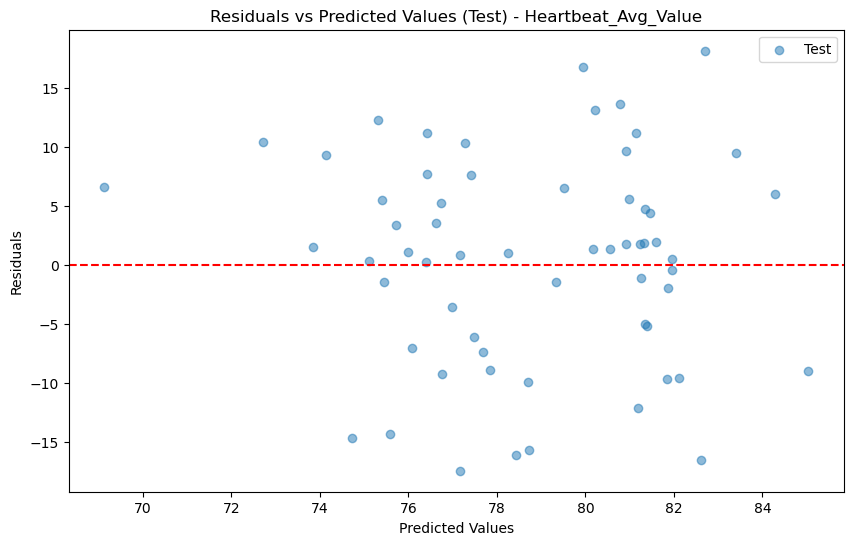

Interpretation for Residuals vs Predicted Values (Test) - Heartbeat_Avg_Value:
Similar to the training residuals, random scatter around the horizontal axis indicates good model performance.
Any patterns or trends might suggest that the model is not capturing some aspects of the data.



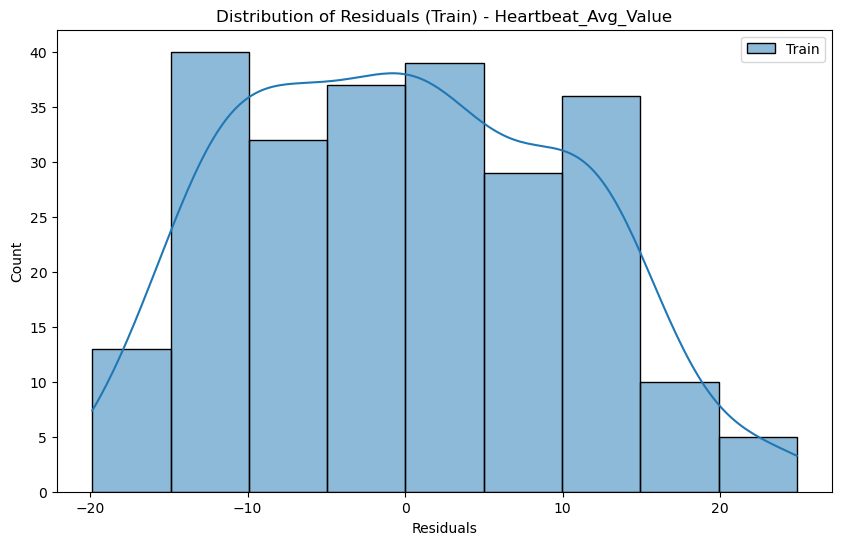

Interpretation for Distribution of Residuals (Train) - Heartbeat_Avg_Value:
A normal distribution of residuals centered around zero suggests that the model's errors are normally distributed.
Skewness or kurtosis in the distribution might indicate issues with the model or data.



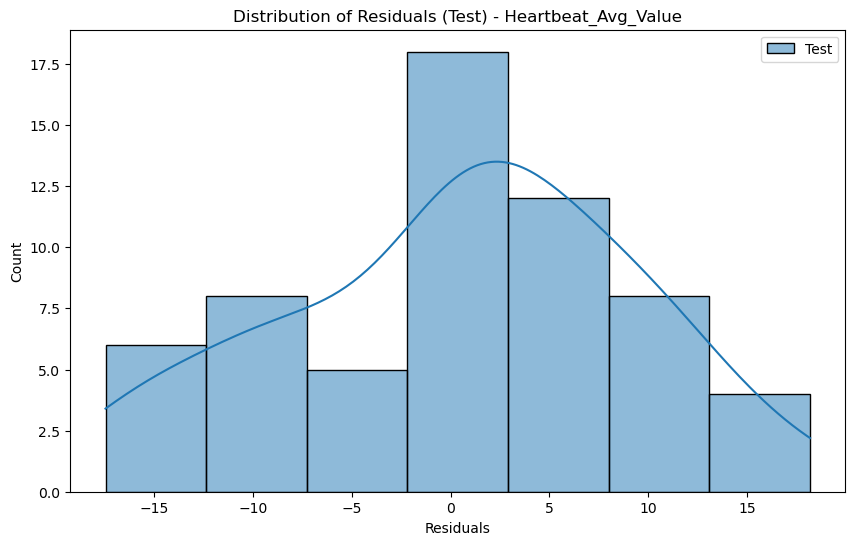

Interpretation for Distribution of Residuals (Test) - Heartbeat_Avg_Value:
A normal distribution of residuals centered around zero for the test set also suggests good model performance.
Deviations from normality might indicate that the model is not capturing all patterns in the data.



In [626]:
def plot_residuals_and_distributions(y_train, y_train_pred, y_test, y_test_pred, target):
    # Calculate residuals
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Plot residuals for training set
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Train')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Values (Train) - {target}')
    plt.legend()
    plt.show()

    # Interpretation for training residuals
    print(f"Interpretation for Residuals vs Predicted Values (Train) - {target}:")
    print("If the residuals are randomly scattered around the horizontal axis (y=0), it suggests that the model's predictions are unbiased.")
    print("Patterns or trends in the residuals might indicate issues such as non-linearity, heteroscedasticity, or outliers.\n")

    # Plot residuals for test set
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred, test_residuals, alpha=0.5, label='Test')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Values (Test) - {target}')
    plt.legend()
    plt.show()

    # Interpretation for test residuals
    print(f"Interpretation for Residuals vs Predicted Values (Test) - {target}:")
    print("Similar to the training residuals, random scatter around the horizontal axis indicates good model performance.")
    print("Any patterns or trends might suggest that the model is not capturing some aspects of the data.\n")

    # Plot the distribution of residuals for training set
    plt.figure(figsize=(10, 6))
    sns.histplot(train_residuals, kde=True, label='Train')
    plt.xlabel('Residuals')
    plt.title(f'Distribution of Residuals (Train) - {target}')
    plt.legend()
    plt.show()

    # Interpretation for training residuals distribution
    print(f"Interpretation for Distribution of Residuals (Train) - {target}:")
    print("A normal distribution of residuals centered around zero suggests that the model's errors are normally distributed.")
    print("Skewness or kurtosis in the distribution might indicate issues with the model or data.\n")

    # Plot the distribution of residuals for test set
    plt.figure(figsize=(10, 6))
    sns.histplot(test_residuals, kde=True, label='Test')
    plt.xlabel('Residuals')
    plt.title(f'Distribution of Residuals (Test) - {target}')
    plt.legend()
    plt.show()

    # Interpretation for test residuals distribution
    print(f"Interpretation for Distribution of Residuals (Test) - {target}:")
    print("A normal distribution of residuals centered around zero for the test set also suggests good model performance.")
    print("Deviations from normality might indicate that the model is not capturing all patterns in the data.\n")

# Example usage for each target
for target in heartbeat_columns:
    # Assuming y_train, y_train_pred, y_test, y_test_pred are defined for each target
    plot_residuals_and_distributions(y_train, y_train_pred, y_test, y_test_pred, target)


## RIDGE REGRESSION

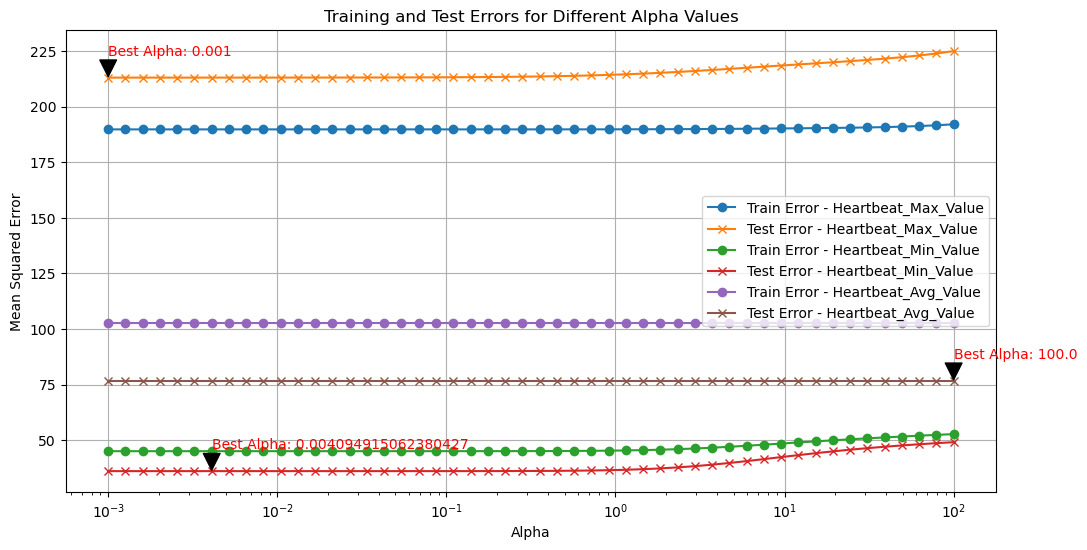

Model Results (Best Alphas):
             Target  Best Alpha  Train Error (MSE)  Test Error (MSE)
Heartbeat_Max_Value    0.001000         189.774064        213.053649
Heartbeat_Min_Value    0.004095          45.076470         36.107870
Heartbeat_Avg_Value  100.000000         102.867623         76.774055

Coefficients:
             Target                  Feature  Best Alpha  Coefficient
Heartbeat_Max_Value            TotalDistance    0.001000    -4.634404
Heartbeat_Max_Value          TrackerDistance    0.001000     4.673854
Heartbeat_Max_Value       VeryActiveDistance    0.001000     4.538454
Heartbeat_Max_Value      FairlyActiveMinutes    0.001000     0.333226
Heartbeat_Max_Value                 Calories    0.001000     0.006051
Heartbeat_Min_Value               TotalSteps    0.004095     0.004288
Heartbeat_Min_Value            TotalDistance    0.004095    10.570579
Heartbeat_Min_Value          TrackerDistance    0.004095   -16.016267
Heartbeat_Min_Value ModeratelyActiveDistance    0.

In [627]:
# Generate a range of alpha values
alpha_values = np.logspace(-3, 2, 50)  # 50 values from 0.001 to 100

# Initialize lists to store errors and coefficients
train_errors = []
test_errors = []
best_alpha_results = []
coefficients_results = []

# Perform model training and evaluation for each target and alpha value
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    for target in heartbeat_columns:
        # Get the selected features for the current target
        selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
        
        # Split the data into training and testing sets
        X = all_merged_data_imputed2_cleaned[selected_features]
        y = all_merged_data_imputed2_cleaned[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the model
        ridge.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = ridge.predict(X_train)
        y_test_pred = ridge.predict(X_test)
        
        # Calculate errors
        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)
        
        # Store the errors
        train_errors.append((alpha, target, train_error))
        test_errors.append((alpha, target, test_error))

# Convert errors to DataFrame for easier plotting
train_errors_df = pd.DataFrame(train_errors, columns=['Alpha', 'Target', 'Train Error'])
test_errors_df = pd.DataFrame(test_errors, columns=['Alpha', 'Target', 'Test Error'])

# Find the best alpha for each target
best_alphas = test_errors_df.loc[test_errors_df.groupby('Target')['Test Error'].idxmin()]

# Plot the errors
plt.figure(figsize=(12, 6))
for target in heartbeat_columns:
    plt.plot(train_errors_df[train_errors_df['Target'] == target]['Alpha'], 
             train_errors_df[train_errors_df['Target'] == target]['Train Error'], 
             label=f'Train Error - {target}', marker='o')
    plt.plot(test_errors_df[test_errors_df['Target'] == target]['Alpha'], 
             test_errors_df[test_errors_df['Target'] == target]['Test Error'], 
             label=f'Test Error - {target}', marker='x')
    
    # Highlight the best alpha
    best_alpha = best_alphas[best_alphas['Target'] == target]['Alpha'].values[0]
    best_test_error = best_alphas[best_alphas['Target'] == target]['Test Error'].values[0]
    plt.annotate(f'Best Alpha: {best_alpha}', 
                 xy=(best_alpha, best_test_error), 
                 xytext=(best_alpha, best_test_error + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), 
                 fontsize=10, color='red')

plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors for Different Alpha Values')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

# Calculate errors and coefficients using the best alphas
for target in heartbeat_columns:
    best_alpha = best_alphas[best_alphas['Target'] == target]['Alpha'].values[0]
    ridge = Ridge(alpha=best_alpha)
    
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    ridge.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    
    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store the results
    best_alpha_results.append({
        'Target': target,
        'Best Alpha': best_alpha,
        'Train Error (MSE)': train_error,
        'Test Error (MSE)': test_error
    })
    
    # Extract and store the coefficients for the best alpha
    coefficients = ridge.coef_
    for feature, coef in zip(selected_features, coefficients):
        coefficients_results.append({
            'Target': target,
            'Feature': feature,
            'Best Alpha': best_alpha,
            'Coefficient': coef
        })

# Convert the results list to DataFrames
model_results_ridge = pd.DataFrame(best_alpha_results)
coefficients_ridge = pd.DataFrame(coefficients_results)

# Display the DataFrames
print("Model Results (Best Alphas):")
print(model_results_ridge.to_string(index=False))
print("\nCoefficients:")
print(coefficients_ridge.to_string(index=False))



#Strong Penalty on Coefficients: A high alpha value like 184.21 imposes a significant penalty on the magnitude of the coefficients. This means the model will heavily penalize large coefficients, pushing them towards zero.
#Reduced Overfitting: Strong regularization helps in reducing overfitting by simplifying the model. It prevents the model from fitting the noise in the training data, which can improve the model’s generalization to new, unseen data.
#Potential Underfitting: While strong regularization can reduce overfitting, it can also lead to underfitting if the alpha value is too high. This happens when the model becomes too simple and fails to capture the underlying patterns in the data.
#Model Interpretation: With high regularization, the model coefficients will be smaller, making the model easier to interpret. However, it might also mean that some important features are given less weight than they deserve.


## LASSO REGRESSION

C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+04, tolerance: 7.541e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.436e+03, tolerance: 1.835e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+04, toleranc

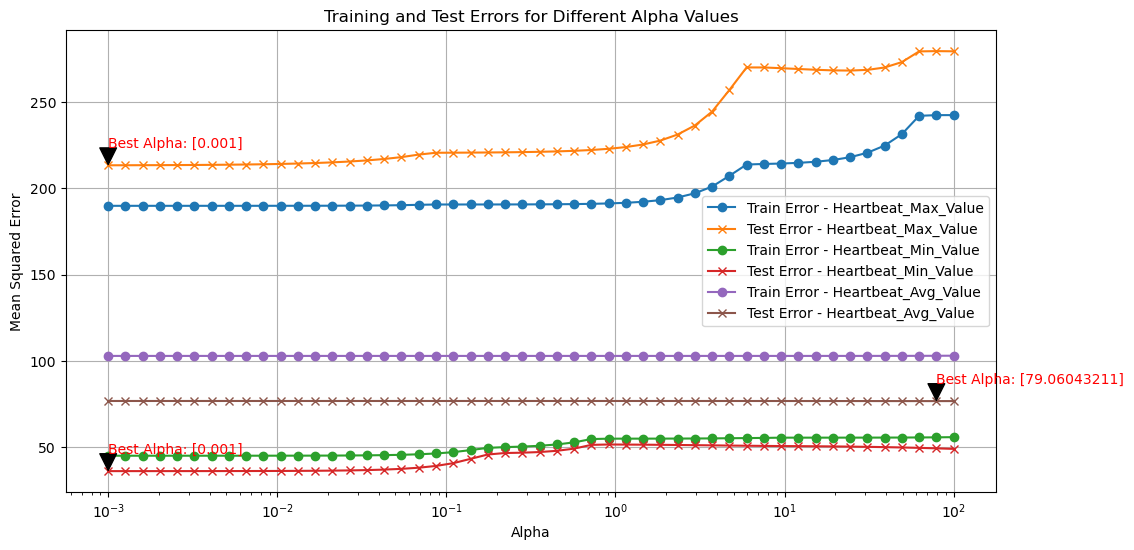

Model Results (Best Alphas):
             Target  Best Alpha  Train Error (MSE)  Test Error (MSE)
Heartbeat_Max_Value    0.001000         189.774740        213.243231
Heartbeat_Min_Value    0.001000          45.079317         36.164083
Heartbeat_Avg_Value   79.060432         102.949379         76.708283

Coefficients:
             Target                  Feature  Best Alpha  Coefficient
Heartbeat_Max_Value            TotalDistance    0.001000    -4.497371
Heartbeat_Max_Value          TrackerDistance    0.001000     4.537016
Heartbeat_Max_Value       VeryActiveDistance    0.001000     4.527801
Heartbeat_Max_Value      FairlyActiveMinutes    0.001000     0.333318
Heartbeat_Max_Value                 Calories    0.001000     0.006053
Heartbeat_Min_Value               TotalSteps    0.001000     0.004323
Heartbeat_Min_Value            TotalDistance    0.001000    10.293577
Heartbeat_Min_Value          TrackerDistance    0.001000   -15.794113
Heartbeat_Min_Value ModeratelyActiveDistance    0.

C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+04, tolerance: 7.541e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.436e+03, tolerance: 1.835e+00
  model = cd_fast.enet_coordinate_descent(


In [628]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate a range of alpha values
alpha_values = np.logspace(-3, 2, 50)  # 50 values from 0.001 to 100

# Initialize lists to store errors and coefficients
train_errors = []
test_errors = []
best_alpha_results = []
coefficients_results = []

# Perform model training and evaluation for each target and alpha value
for alpha in alpha_values:
    lasso = Lasso(alpha=float(alpha))  # Ensure alpha is a float
    for target in heartbeat_columns:
        # Get the selected features for the current target
        selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
        
        # Split the data into training and testing sets
        X = all_merged_data_imputed2_cleaned[selected_features]
        y = all_merged_data_imputed2_cleaned[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the model
        lasso.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = lasso.predict(X_train)
        y_test_pred = lasso.predict(X_test)
        
        # Calculate errors
        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)
        
        # Store the errors
        train_errors.append((float(alpha), target, train_error))
        test_errors.append((float(alpha), target, test_error))

# Convert errors to DataFrame for easier plotting
train_errors_df = pd.DataFrame(train_errors, columns=['Alpha', 'Target', 'Train Error'])
test_errors_df = pd.DataFrame(test_errors, columns=['Alpha', 'Target', 'Test Error'])

# Find the best alpha for each target
best_alphas = test_errors_df.loc[test_errors_df.groupby('Target')['Test Error'].idxmin()]

# Plot the errors
plt.figure(figsize=(12, 6))
for target in heartbeat_columns:
    plt.plot(train_errors_df[train_errors_df['Target'] == target]['Alpha'], 
             train_errors_df[train_errors_df['Target'] == target]['Train Error'], 
             label=f'Train Error - {target}', marker='o')
    plt.plot(test_errors_df[test_errors_df['Target'] == target]['Alpha'], 
             test_errors_df[test_errors_df['Target'] == target]['Test Error'], 
             label=f'Test Error - {target}', marker='x')
    
    # Highlight the best alpha
    best_alpha = best_alphas[best_alphas['Target'] == target]['Alpha'].values
    best_test_error = best_alphas[best_alphas['Target'] == target]['Test Error'].values
    plt.annotate(f'Best Alpha: {best_alpha}', 
                 xy=(best_alpha, best_test_error), 
                 xytext=(best_alpha, best_test_error + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), 
                 fontsize=10, color='red')

plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors for Different Alpha Values')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

# Calculate errors and coefficients using the best alphas
for target in heartbeat_columns:
    best_alpha = best_alphas[best_alphas['Target'] == target]['Alpha'].item()
    lasso = Lasso(alpha=best_alpha)
    
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    lasso.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    
    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store the results
    best_alpha_results.append({
        'Target': target,
        'Best Alpha': best_alpha,
        'Train Error (MSE)': train_error,
        'Test Error (MSE)': test_error
    })
    
    # Extract and store the coefficients for the best alpha
    coefficients = lasso.coef_
    for feature, coef in zip(selected_features, coefficients):
        coefficients_results.append({
            'Target': target,
            'Feature': feature,
            'Best Alpha': best_alpha,
            'Coefficient': coef
        })

# Convert the results list to DataFrames
model_results_lasso = pd.DataFrame(best_alpha_results)
coefficients_lasso = pd.DataFrame(coefficients_results)

# Display the DataFrames
print("Model Results (Best Alphas):")
print(model_results_lasso.to_string(index=False))
print("\nCoefficients:")
print(coefficients_lasso.to_string(index=False))






## ELASTIC NET REGRESSION 

C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e+04, tolerance: 7.541e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.730e+03, tolerance: 1.835e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

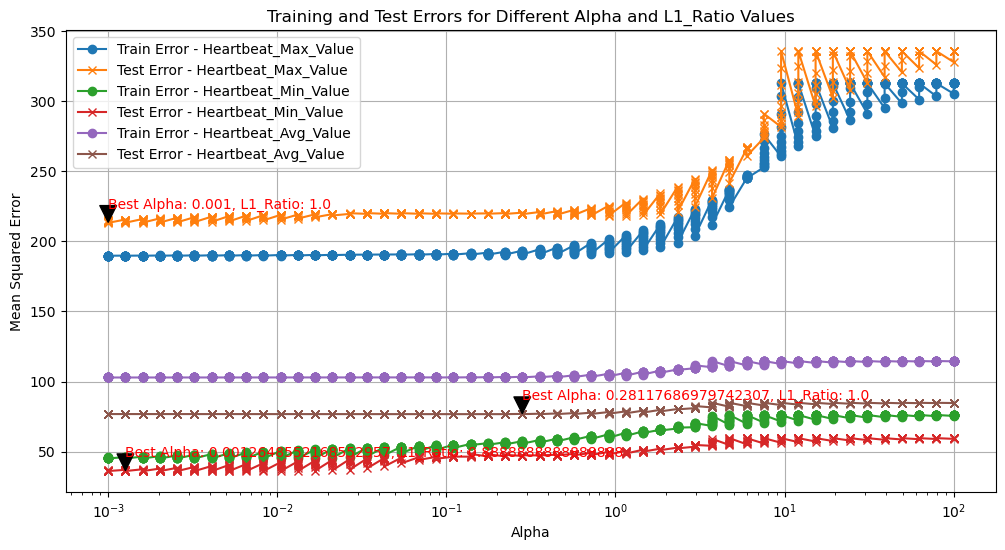

Model Results (Best Alphas and L1_Ratios):
             Target  Best Alpha  Best L1_Ratio  Train Error (MSE)  Test Error (MSE)
Heartbeat_Max_Value    0.001000       1.000000         189.775096        213.283098
Heartbeat_Min_Value    0.001265       0.888889          45.118054         36.037230
Heartbeat_Avg_Value    0.281177       1.000000         102.946683         76.708284

Coefficients:
             Target                  Feature  Best Alpha  Best L1_Ratio  Coefficient
Heartbeat_Max_Value            TotalDistance    0.001000       1.000000   -13.312113
Heartbeat_Max_Value          TrackerDistance    0.001000       1.000000    13.143950
Heartbeat_Max_Value       VeryActiveDistance    0.001000       1.000000     6.093733
Heartbeat_Max_Value      FairlyActiveMinutes    0.001000       1.000000     4.462589
Heartbeat_Max_Value                 Calories    0.001000       1.000000     3.331013
Heartbeat_Min_Value               TotalSteps    0.001265       0.888889    17.506970
Heartbeat_M

In [629]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Generate a range of alpha values
alpha_values = np.logspace(-3, 2, 50)  # 50 values from 0.001 to 100

# Define a range of l1_ratio values
l1_ratio_values = np.linspace(0, 1, 10)  # 10 values from 0 to 1

# Initialize lists to store errors and coefficients
train_errors = []
test_errors = []
best_params_results = []
coefficients_results = []

# Perform model training and evaluation for each target, alpha, and l1_ratio value
for alpha in alpha_values:
    for l1_ratio in l1_ratio_values:
        elastic_net = ElasticNet(alpha=float(alpha), l1_ratio=float(l1_ratio), max_iter=10000)  # Increased iterations
        for target in heartbeat_columns:
            # Get the selected features for the current target
            selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
            
            # Split the data into training and testing sets
            X = all_merged_data_imputed2_cleaned[selected_features]
            y = all_merged_data_imputed2_cleaned[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Standardize the features
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Train the model
            elastic_net.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = elastic_net.predict(X_train)
            y_test_pred = elastic_net.predict(X_test)
            
            # Calculate errors
            train_error = mean_squared_error(y_train, y_train_pred)
            test_error = mean_squared_error(y_test, y_test_pred)
            
            # Store the errors
            train_errors.append((float(alpha), float(l1_ratio), target, train_error))
            test_errors.append((float(alpha), float(l1_ratio), target, test_error))

# Convert errors to DataFrame for easier plotting
train_errors_df = pd.DataFrame(train_errors, columns=['Alpha', 'L1_Ratio', 'Target', 'Train Error'])
test_errors_df = pd.DataFrame(test_errors, columns=['Alpha', 'L1_Ratio', 'Target', 'Test Error'])

# Find the best alpha and l1_ratio for each target
best_params = test_errors_df.loc[test_errors_df.groupby('Target')['Test Error'].idxmin()]

# Plot the errors
plt.figure(figsize=(12, 6))
for target in heartbeat_columns:
    plt.plot(train_errors_df[train_errors_df['Target'] == target]['Alpha'], 
             train_errors_df[train_errors_df['Target'] == target]['Train Error'], 
             label=f'Train Error - {target}', marker='o')
    plt.plot(test_errors_df[test_errors_df['Target'] == target]['Alpha'], 
             test_errors_df[test_errors_df['Target'] == target]['Test Error'], 
             label=f'Test Error - {target}', marker='x')
    
    # Highlight the best alpha and l1_ratio
    best_alpha = best_params[best_params['Target'] == target]['Alpha'].item()
    best_l1_ratio = best_params[best_params['Target'] == target]['L1_Ratio'].item()
    best_test_error = best_params[best_params['Target'] == target]['Test Error']
    plt.annotate(f'Best Alpha: {best_alpha}, L1_Ratio: {best_l1_ratio}', 
                 xy=(best_alpha, best_test_error), 
                 xytext=(best_alpha, best_test_error + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), 
                 fontsize=10, color='red')

plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors for Different Alpha and L1_Ratio Values')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

# Calculate errors and coefficients using the best alphas and l1_ratios
for target in heartbeat_columns:
    best_alpha = best_params[best_params['Target'] == target]['Alpha'].item()
    best_l1_ratio = best_params[best_params['Target'] == target]['L1_Ratio'].item()
    elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)  # Increased iterations
    
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train the model
    elastic_net.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = elastic_net.predict(X_train)
    y_test_pred = elastic_net.predict(X_test)
    
    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store the results
    best_params_results.append({
        'Target': target,
        'Best Alpha': best_alpha,
        'Best L1_Ratio': best_l1_ratio,
        'Train Error (MSE)': train_error,
        'Test Error (MSE)': test_error
    })
    
    # Extract and store the coefficients for the best alpha and l1_ratio
    coefficients = elastic_net.coef_
    for feature, coef in zip(selected_features, coefficients):
        coefficients_results.append({
            'Target': target,
            'Feature': feature,
            'Best Alpha': best_alpha,
            'Best L1_Ratio': best_l1_ratio,
            'Coefficient': coef
        })

# Convert the results list to DataFrames
model_results_elastic_net = pd.DataFrame(best_params_results)
coefficients_elastic_net = pd.DataFrame(coefficients_results)

# Display the DataFrames
print("Model Results (Best Alphas and L1_Ratios):")
print(model_results_elastic_net.to_string(index=False))
print("\nCoefficients:")
print(coefficients_elastic_net.to_string(index=False))



#l1_ratio: This parameter determines the mix of L1 and L2 regularization.
#0 < l1_ratio < 1: The penalty is a combination of L1 and L2, balancing between Ridge and Lasso
#l1_ratio = 0: The penalty is purely L2 (Ridge regression).
#l1_ratio = 1: The penalty is purely L1 (Lasso regression).


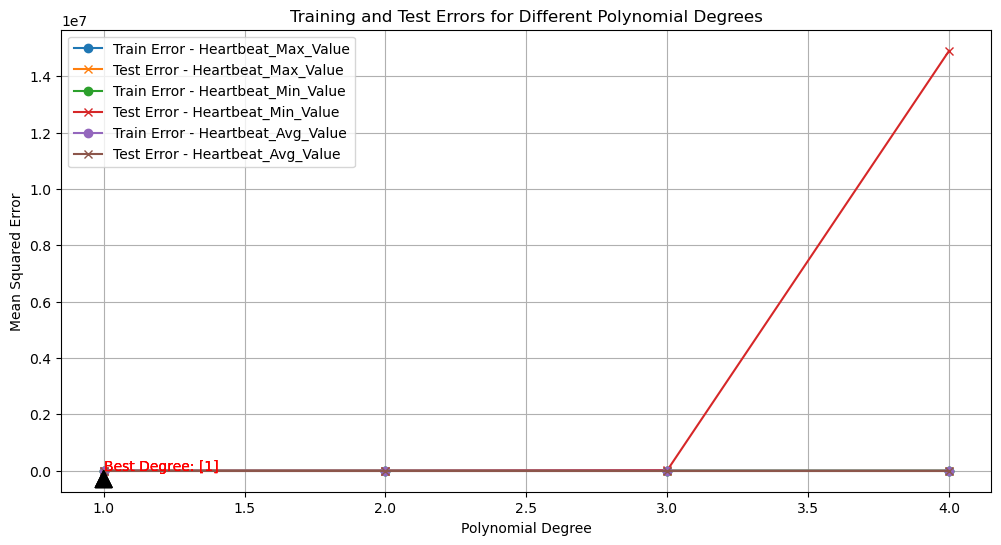

Model Results (Best Degree):
             Target  Best Degree  Train Error (MSE)  Test Error (MSE)
Heartbeat_Max_Value            1         189.774064        213.052067
Heartbeat_Min_Value            1          45.076464         36.107885
Heartbeat_Avg_Value            1         102.867623         76.774063

Coefficients:
             Target                  Feature  Best Degree  Coefficient
Heartbeat_Max_Value            TotalDistance            1    -4.635534
Heartbeat_Max_Value          TrackerDistance            1     4.674983
Heartbeat_Max_Value       VeryActiveDistance            1     4.538550
Heartbeat_Max_Value      FairlyActiveMinutes            1     0.333224
Heartbeat_Max_Value                 Calories            1     0.006051
Heartbeat_Min_Value               TotalSteps            1     0.004289
Heartbeat_Min_Value            TotalDistance            1    10.583945
Heartbeat_Min_Value          TrackerDistance            1   -16.030291
Heartbeat_Min_Value ModeratelyActiveD

In [630]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define a range of polynomial degrees to test
degrees = range(1, 5)  

# Initialize lists to store errors and coefficients
train_errors = []
test_errors = []
best_degree_results = []
coefficients_results = []

# Perform model training and evaluation for each target and polynomial degree
for degree in degrees:
    for target in heartbeat_columns:
        # Get the selected features for the current target
        selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
        
        # Split the data into training and testing sets
        X = all_merged_data_imputed2_cleaned[selected_features]
        y = all_merged_data_imputed2_cleaned[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Create a pipeline for polynomial features and linear regression
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate errors
        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)
        
        # Store the errors
        train_errors.append((degree, target, train_error))
        test_errors.append((degree, target, test_error))

# Convert errors to DataFrame for easier plotting
train_errors_df = pd.DataFrame(train_errors, columns=['Degree', 'Target', 'Train Error'])
test_errors_df = pd.DataFrame(test_errors, columns=['Degree', 'Target', 'Test Error'])

# Find the best polynomial degree for each target
best_degrees = test_errors_df.loc[test_errors_df.groupby('Target')['Test Error'].idxmin()]

# Plot the errors
plt.figure(figsize=(12, 6))
for target in heartbeat_columns:
    plt.plot(train_errors_df[train_errors_df['Target'] == target]['Degree'], 
             train_errors_df[train_errors_df['Target'] == target]['Train Error'], 
             label=f'Train Error - {target}', marker='o')
    plt.plot(test_errors_df[test_errors_df['Target'] == target]['Degree'], 
             test_errors_df[test_errors_df['Target'] == target]['Test Error'], 
             label=f'Test Error - {target}', marker='x')
    
    # Highlight the best degree
    best_degree = best_degrees[best_degrees['Target'] == target]['Degree'].values
    best_test_error = best_degrees[best_degrees['Target'] == target]['Test Error'].values
    plt.annotate(f'Best Degree: {best_degree}', 
                 xy=(best_degree, best_test_error), 
                 xytext=(best_degree, best_test_error + 10), 
                 arrowprops=dict(facecolor='black', shrink=0.05), 
                 fontsize=10, color='red')

plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors for Different Polynomial Degrees')
plt.legend()
plt.grid(True)
plt.show()

# Calculate errors and coefficients using the best degrees
for target in heartbeat_columns:
    best_degree = best_degrees[best_degrees['Target'] == target]['Degree'].values[0]
    
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a pipeline for polynomial features and linear regression
    model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store the results
    best_degree_results.append({
        'Target': target,
        'Best Degree': best_degree,
        'Train Error (MSE)': train_error,
        'Test Error (MSE)': test_error
    })
    
    # Extract and store the coefficients for the best degree
    coefficients = model.named_steps['linearregression'].coef_
    for feature, coef in zip(selected_features, coefficients[1:]):  # Skip the intercept
        coefficients_results.append({
            'Target': target,
            'Feature': feature,
            'Best Degree': best_degree,
            'Coefficient': coef
        })

# Convert the results list to a DataFrame
model_results_polynomial = pd.DataFrame(best_degree_results)
coefficients_Polynomial = pd.DataFrame(coefficients_results)

# Display the DataFrame
print("Model Results (Best Degree):")
print(model_results_polynomial.to_string(index=False))
print("\nCoefficients:")
print(coefficients_Polynomial.to_string(index=False))


In [631]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to remove outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Exclude rows with missing values in heartbeat_columns
all_merged_data_imputed2_cleaned = all_merged_data_imputed2.dropna(subset=heartbeat_columns)

# Remove outliers from activity_columns and heartbeat_columns
for column in activity_columns + heartbeat_columns:
    all_merged_data_imputed2_cleaned = remove_outliers_iqr(all_merged_data_imputed2_cleaned, column)

# Initialize lists to store errors and coefficients
errors = []
coefficients_results = []
best_params_results = []

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform model training and evaluation for each target
for target in heartbeat_columns:
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store the errors
    errors.append({
        'Target': target,
        'Train Error (MSE)': train_error,
        'Test Error (MSE)': test_error
    })
    
    # Feature importances
    feature_importances = best_model.feature_importances_
    for feature, importance in zip(selected_features, feature_importances):
        coefficients_results.append({
            'Target': target,
            'Feature': feature,
            'Importance': importance
        })
    
    # Store best parameters
    best_params_results.append({
        'Target': target,
        'Best Parameters': best_params
    })

# Convert the results list to DataFrames
model_results_tree = pd.DataFrame(errors)
coefficients_tree = pd.DataFrame(coefficients_results)
best_params_tree = pd.DataFrame(best_params_results)

# Display the DataFrames
print("Training and Test Errors:")
print(model_results_tree.to_string(index=False))
print("\nFeature Importances:")
print(coefficients_tree.to_string(index=False))
print("\nBest Parameters for Each Target:")
print(best_params_tree.to_string(index=False))


Training and Test Errors:
             Target  Train Error (MSE)  Test Error (MSE)
Heartbeat_Max_Value         137.694714        232.504843
Heartbeat_Min_Value          14.927745         39.524282
Heartbeat_Avg_Value          73.752920         71.841050

Feature Importances:
             Target                  Feature  Importance
Heartbeat_Max_Value            TotalDistance    0.067399
Heartbeat_Max_Value          TrackerDistance    0.070515
Heartbeat_Max_Value       VeryActiveDistance    0.096980
Heartbeat_Max_Value      FairlyActiveMinutes    0.682480
Heartbeat_Max_Value                 Calories    0.082626
Heartbeat_Min_Value               TotalSteps    0.190552
Heartbeat_Min_Value            TotalDistance    0.076730
Heartbeat_Min_Value          TrackerDistance    0.013386
Heartbeat_Min_Value ModeratelyActiveDistance    0.010880
Heartbeat_Min_Value        VeryActiveMinutes    0.085327
Heartbeat_Min_Value      FairlyActiveMinutes    0.001713
Heartbeat_Min_Value         SedentaryMin

Training and Test Errors:
             Target  Train Error (MSE)  Test Error (MSE)
Heartbeat_Max_Value         126.703020        210.502417
Heartbeat_Min_Value           4.237272         31.470084
Heartbeat_Avg_Value          70.278480         70.085969

Feature Importances:
             Target                  Feature  Importance
Heartbeat_Max_Value            TotalDistance    0.052845
Heartbeat_Max_Value          TrackerDistance    0.052123
Heartbeat_Max_Value       VeryActiveDistance    0.214887
Heartbeat_Max_Value      FairlyActiveMinutes    0.507689
Heartbeat_Max_Value                 Calories    0.172456
Heartbeat_Min_Value               TotalSteps    0.104249
Heartbeat_Min_Value            TotalDistance    0.059239
Heartbeat_Min_Value          TrackerDistance    0.065972
Heartbeat_Min_Value ModeratelyActiveDistance    0.030633
Heartbeat_Min_Value        VeryActiveMinutes    0.070819
Heartbeat_Min_Value      FairlyActiveMinutes    0.016876
Heartbeat_Min_Value         SedentaryMin

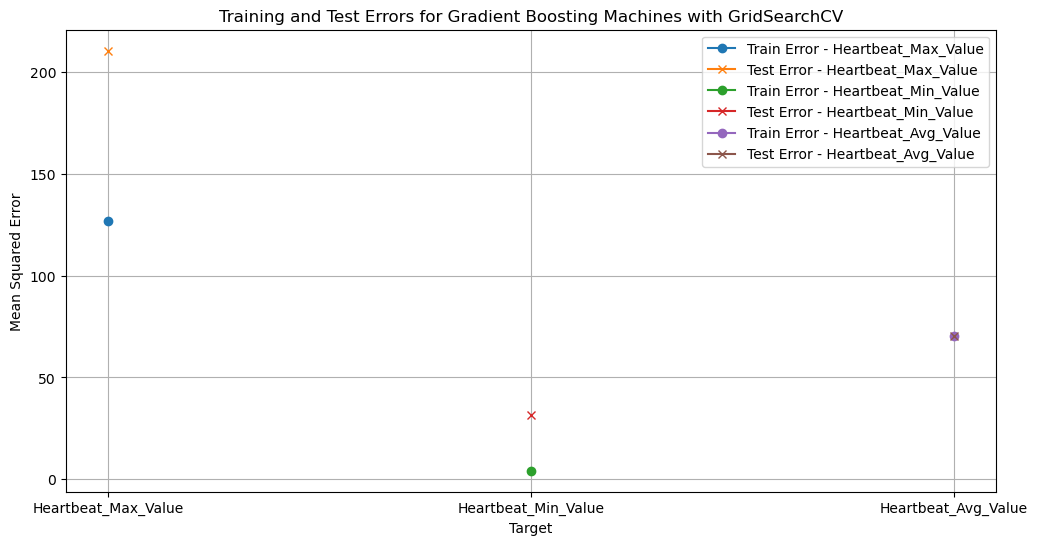

In [632]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Initialize lists to store errors and coefficients
errors = []
coefficients_results = []
best_params_results = []

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform model training and evaluation for each target
for target in heartbeat_columns:
    # Get the selected features for the current target
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    
    # Split the data into training and testing sets
    X = all_merged_data_imputed2_cleaned[selected_features]
    y = all_merged_data_imputed2_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store the errors
    errors.append({
        'Target': target,
        'Train Error (MSE)': train_error,
        'Test Error (MSE)': test_error
    })
    
    # Feature importances
    feature_importances = best_model.feature_importances_
    for feature, importance in zip(selected_features, feature_importances):
        coefficients_results.append({
            'Target': target,
            'Feature': feature,
            'Importance': importance
        })
    
    # Store best parameters
    best_params_results.append({
        'Target': target,
        'Best Parameters': best_params
    })

# Convert the results list to DataFrames
model_results_gbm = pd.DataFrame(errors)
coefficients_gbm = pd.DataFrame(coefficients_results)
best_params_gbm = pd.DataFrame(best_params_results)

# Display the DataFrames
print("Training and Test Errors:")
print(model_results_gbm.to_string(index=False))
print("\nFeature Importances:")
print(coefficients_gbm.to_string(index=False))
print("\nBest Parameters for Each Target:")
print(best_params_gbm.to_string(index=False))

# Plot the errors
plt.figure(figsize=(12, 6))
for target in heartbeat_columns:
    plt.plot(model_results_gbm[model_results_gbm['Target'] == target]['Target'], 
             model_results_gbm[model_results_gbm['Target'] == target]['Train Error (MSE)'], 
             label=f'Train Error - {target}', marker='o')
    plt.plot(model_results_gbm[model_results_gbm['Target'] == target]['Target'], 
             model_results_gbm[model_results_gbm['Target'] == target]['Test Error (MSE)'], 
             label=f'Test Error - {target}', marker='x')

plt.xlabel('Target')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors for Gradient Boosting Machines with GridSearchCV')
plt.legend()
plt.grid(True)
plt.show()




In [633]:
# Add a column to each DataFrame to indicate the model type
model_results_df['Model'] = 'Linear'
model_results_ridge['Model'] = 'Ridge'
model_results_lasso['Model'] = 'Lasso'
model_results_elastic_net['Model'] = 'Elastic Net'
model_results_polynomial['Model'] = 'Polynomial'
model_results_tree['Model'] = 'Decision Tree'
model_results_gbm['Model'] = 'Gradient Boosting'

# Combine all DataFrames
combined_results = pd.concat([
    model_results_df, 
    model_results_ridge, 
    model_results_lasso, 
    model_results_elastic_net, 
    model_results_polynomial,
    model_results_tree,
    model_results_gbm
])

# Select only the relevant columns and reorder them
combined_results = combined_results[['Model', 'Train Error (MSE)', 'Test Error (MSE)', 'Target']]

# Calculate the difference and add a new column
combined_results['Error Difference (MSE)'] = combined_results['Train Error (MSE)'] - combined_results['Test Error (MSE)']

# Display results for each target separately
for target in heartbeat_columns:
    target_results = combined_results[combined_results['Target'] == target]
    target_results = target_results.drop(columns=['Target'])  # Remove the Target column
    print(f"Results for {target}:\n")
    print(target_results.to_string(index=False))
    print("\n" + "="*50 + "\n")

# Train Error: Measures how well the model fits the training data.
# Test Error: Measures how well the model generalizes to new, unseen data.


Results for Heartbeat_Max_Value:

            Model  Train Error (MSE)  Test Error (MSE)  Error Difference (MSE)
           Linear         189.774064        213.052067              -23.278002
            Ridge         189.774064        213.053649              -23.279584
            Lasso         189.774740        213.243231              -23.468491
      Elastic Net         189.775096        213.283098              -23.508003
       Polynomial         189.774064        213.052067              -23.278002
    Decision Tree         137.694714        232.504843              -94.810129
Gradient Boosting         126.703020        210.502417              -83.799397


Results for Heartbeat_Min_Value:

            Model  Train Error (MSE)  Test Error (MSE)  Error Difference (MSE)
           Linear          45.076464         36.107885                8.968578
            Ridge          45.076470         36.107870                8.968601
            Lasso          45.079317         36.164083       

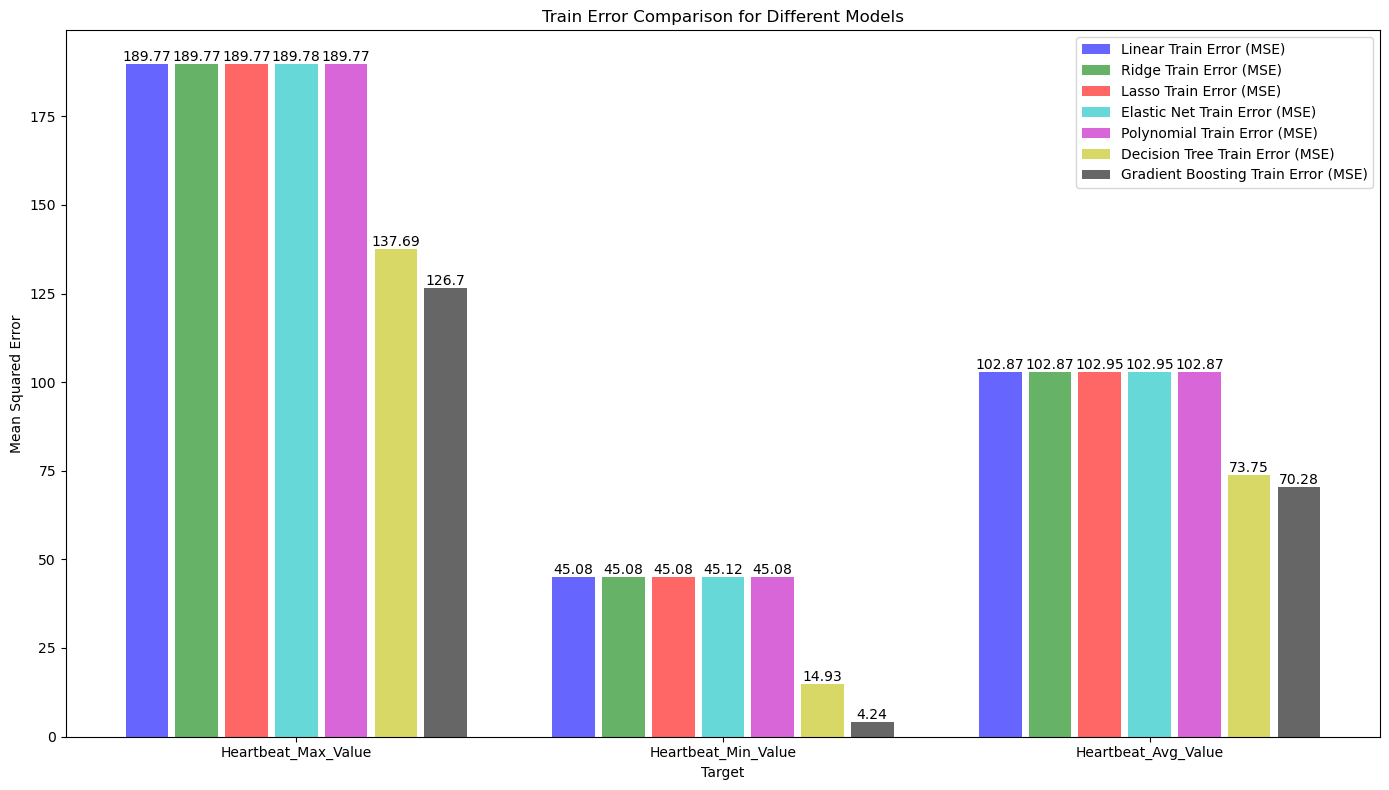

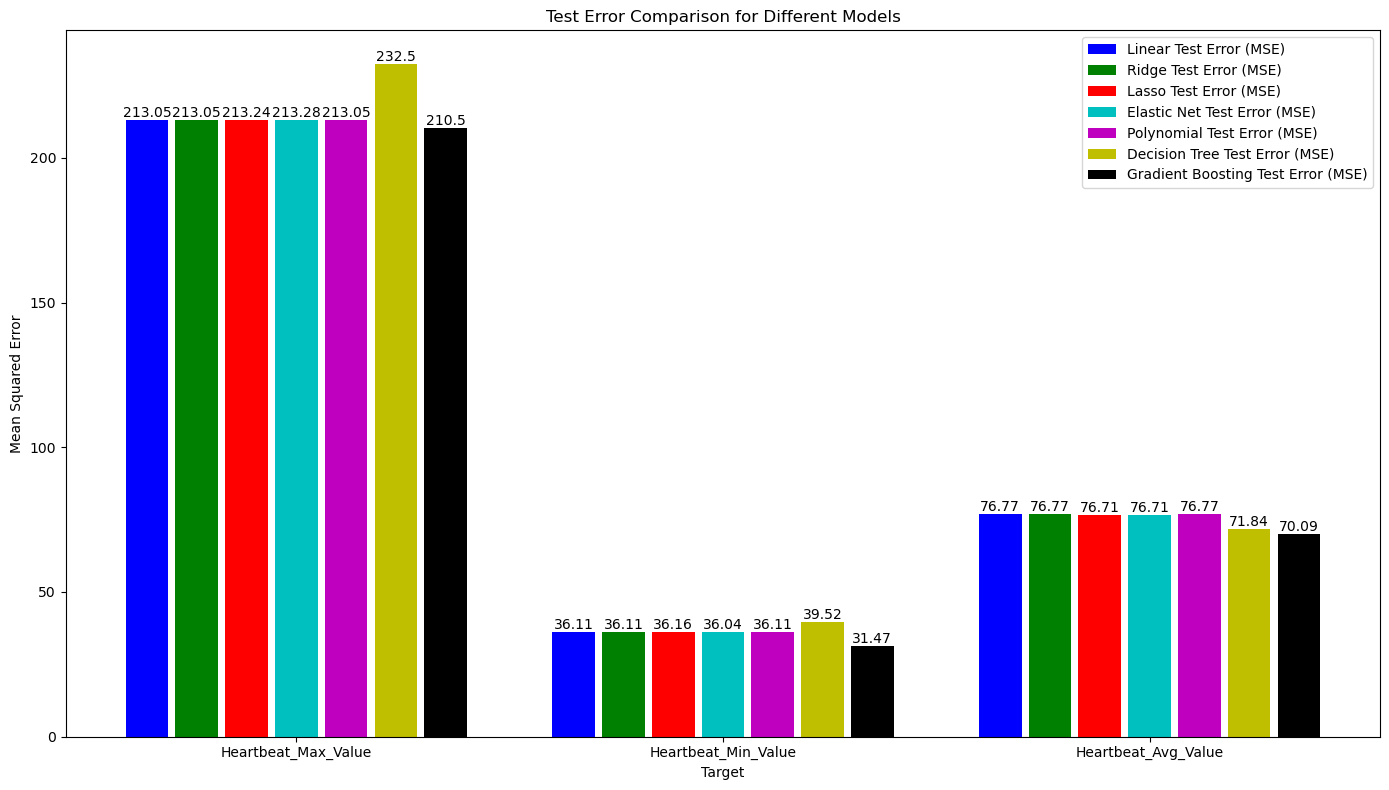

In [634]:
# Plot the training errors
models_to_plot = combined_results['Model'].unique()
bar_width = 0.1  # Adjust the bar width to fit well with the spacing
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for different models
fig, ax = plt.subplots(figsize=(14, 8))

# Offset for each bar
offset = np.linspace(-bar_width * len(models_to_plot) / 2, bar_width * len(models_to_plot) / 2, len(models_to_plot))

for i, model_name in enumerate(models_to_plot):
    model_df = combined_results[combined_results['Model'] == model_name]
    index = np.arange(len(heartbeat_columns))
    train_errors = model_df['Train Error (MSE)'].values
    bar_train = plt.bar(index + offset[i], train_errors, bar_width, label=f'{model_name} Train Error (MSE)', color=colors[i], alpha=0.6)
    
    # Add values on top of bars
    for bar in bar_train:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Mean Squared Error')
plt.title('Train Error Comparison for Different Models')
plt.xticks(index, heartbeat_columns)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the testing errors
fig, ax = plt.subplots(figsize=(14, 8))

for i, model_name in enumerate(models_to_plot):
    model_df = combined_results[combined_results['Model'] == model_name]
    index = np.arange(len(heartbeat_columns))
    test_errors = model_df['Test Error (MSE)'].values
    bar_test = plt.bar(index + offset[i], test_errors, bar_width, label=f'{model_name} Test Error (MSE)', color=colors[i])
    
    # Add values on top of bars
    for bar in bar_test:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Mean Squared Error')
plt.title('Test Error Comparison for Different Models')
plt.xticks(index, heartbeat_columns)
plt.legend()
plt.tight_layout()
plt.show()


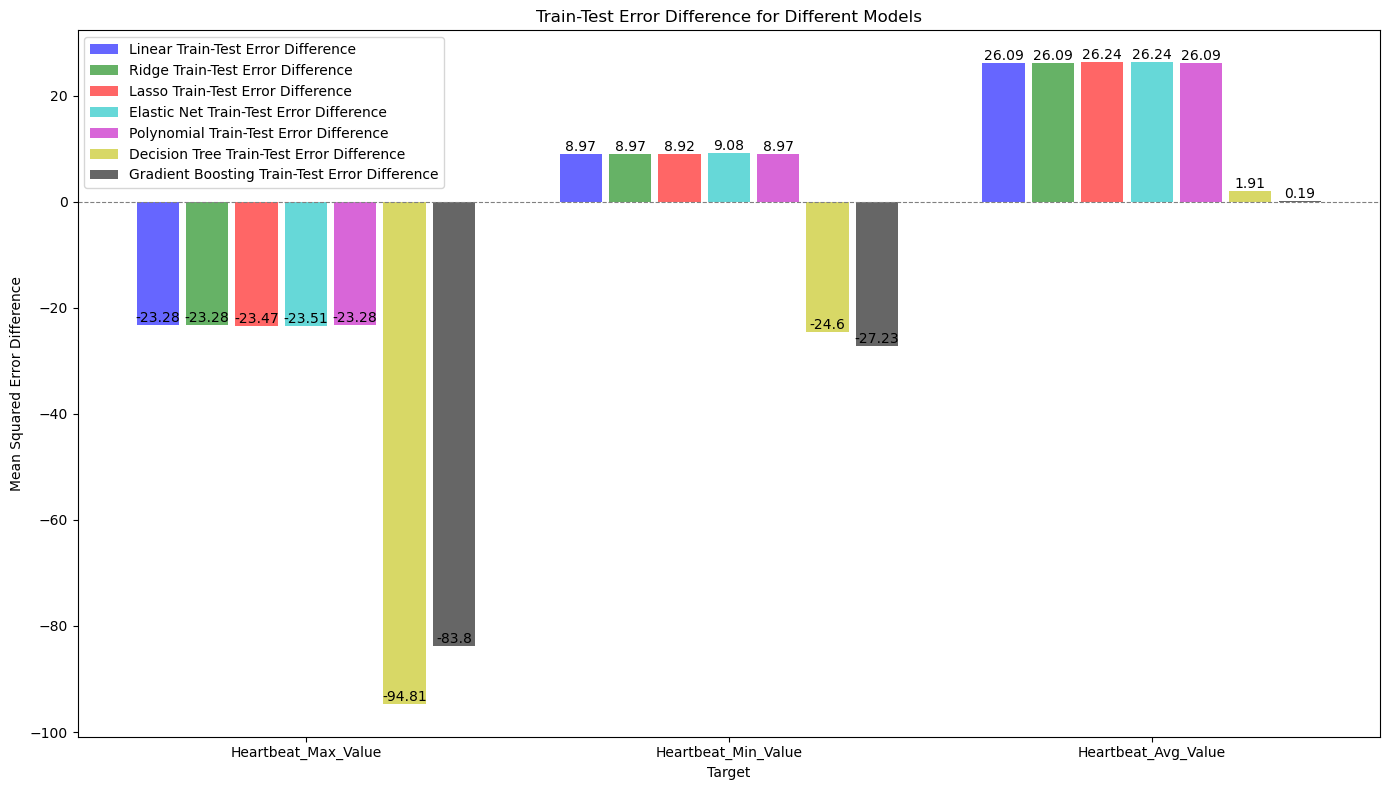

In [635]:
# Plot the difference between train error and test error
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate the difference and create the bar plot
for i, model_name in enumerate(models_to_plot):
    model_df = combined_results[combined_results['Model'] == model_name]
    index = np.arange(len(heartbeat_columns))
    train_errors = model_df['Train Error (MSE)'].values
    test_errors = model_df['Test Error (MSE)'].values
    error_difference = train_errors - test_errors  # Calculate the difference

    bar_diff = plt.bar(index + offset[i], error_difference, bar_width, 
                        label=f'{model_name} Train-Test Error Difference', 
                        color=colors[i], alpha=0.6)

    # Add values on top of bars
    for bar in bar_diff:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Mean Squared Error Difference')
plt.title('Train-Test Error Difference for Different Models')
plt.xticks(index, heartbeat_columns)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a line at y=0 for reference
plt.legend()
plt.tight_layout()
plt.show()

In [636]:
#Evaluating the behavior of the difference between training and testing error (more stable model), we are going to choose:
#Hearbeat_Max_Value = Linear Regression
#Hearbeat_Min_Value = Linear Regression
#Hearbeat_Avg_Value = Gradient Boosting
#Gradient Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

# Start with all_merged_data_imputed2
all_merged_data_hearbeatimputation = all_merged_data_imputed2.copy()
print(f"Shape of all_merged_data_hearbeatimputation: {all_merged_data_hearbeatimputation.shape}")

# Initialize the Linear Regression model
linear_regression = LinearRegression()

# Initialize a list to store the model results
model_results = []
targets = ['Heartbeat_Max_Value', 'Heartbeat_Min_Value']

for target in targets:
    selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
    selected_features = [feature for feature in selected_features if feature in all_merged_data_hearbeatimputation.columns]

    X = all_merged_data_hearbeatimputation[selected_features]
    y = all_merged_data_hearbeatimputation[target]

    mask = y.notnull()
    X_train = X[mask]
    y_train = y[mask]

    print(f"Training on target: {target} - Training Size: {len(y_train)}")

    try:
        # Fit the model directly on the available data
        linear_regression.fit(X_train, y_train)

        missing_mask = y.isnull()
        X_missing = X[missing_mask]

        if not X_missing.empty:
            predicted_values = linear_regression.predict(X_missing)
            all_merged_data_hearbeatimputation.loc[missing_mask, target] = predicted_values
            
            # Output how many values were imputed
            print(f"Imputed {len(predicted_values)} values for {target}.")
            model_results.append({'Target': target, 'Imputed Size': len(X_missing)})

            # Calculate MSE for the imputed values
            mse = mean_squared_error(y[mask], linear_regression.predict(X[mask]))
            model_results[-1].update({'Train Error (MSE)': mse})
            print(f"Train Error (MSE) for {target}: {mse:.4f}")

        else:
            print(f"No missing values to impute for {target}.")

    except ValueError as e:
        print(f"Error for target {target}: {e}")
    except AttributeError as e:
        print(f"Error for target {target}: {e}")

model_results_df = pd.DataFrame(model_results)

# Display the DataFrame
print("Model Results:")
print(model_results_df.to_string(index=False))

# Save the DataFrame to an Excel file
excel_file_path = 'all_merged_data_imputed_hearbeat1.xlsx'
all_merged_data_hearbeatimputation.to_excel(excel_file_path, index=False)
print(f"File saved as {excel_file_path}")



Shape of all_merged_data_hearbeatimputation: (861, 27)
Training on target: Heartbeat_Max_Value - Training Size: 365
Imputed 496 values for Heartbeat_Max_Value.
Train Error (MSE) for Heartbeat_Max_Value: 282.0871
Training on target: Heartbeat_Min_Value - Training Size: 365
Imputed 496 values for Heartbeat_Min_Value.
Train Error (MSE) for Heartbeat_Min_Value: 43.5033
Model Results:
             Target  Imputed Size  Train Error (MSE)
Heartbeat_Max_Value           496         282.087066
Heartbeat_Min_Value           496          43.503294
File saved as all_merged_data_imputed_hearbeat1.xlsx


In [637]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Start with all_merged_data_hearbeatimputation
all_merged_data_hearbeatimputation = all_merged_data_hearbeatimputation.copy()
print(f"Shape of all_merged_data_hearbeatimputation: {all_merged_data_hearbeatimputation.shape}")

# Define the target for imputation
target = 'Heartbeat_Avg_Value'

# Get the selected features for the current target
selected_features = selected_features_df[selected_features_df['Target'] == target]['Feature'].tolist()
selected_features = [feature for feature in selected_features if feature in all_merged_data_hearbeatimputation.columns]

# Split the data into features and target
X = all_merged_data_hearbeatimputation[selected_features]
y = all_merged_data_hearbeatimputation[target]

# Train on non-missing values
mask = y.notnull()
X_train = X[mask]
y_train = y[mask]

print(f"Training on target: {target} - Training Size: {len(y_train)}")

# Initialize the Gradient Boosting model with the specified parameters
gb_model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

try:
    # Fit the model
    gb_model.fit(X_train, y_train)

    # Predict missing values
    missing_mask = y.isnull()
    X_missing = X[missing_mask]

    if not X_missing.empty:
        predicted_values = gb_model.predict(X_missing)
        all_merged_data_hearbeatimputation.loc[missing_mask, target] = predicted_values
        
        # Output how many values were imputed
        print(f"Imputed {len(predicted_values)} values for {target}.")
        
        # (Optional) You can include a performance evaluation on the training set if needed
        y_train_pred = gb_model.predict(X_train)
        train_error = mean_squared_error(y_train, y_train_pred)
        print(f"Train Error (MSE) for {target}: {train_error:.4f}")

    else:
        print(f"No missing values to impute for {target}.")

except ValueError as e:
    print(f"Error for target {target}: {e}")
except AttributeError as e:
    print(f"Error for target {target}: {e}")

# Save the DataFrame to an Excel file
excel_file_path = 'all_merged_data_imputed_hearbeat_avg.xlsx'
all_merged_data_hearbeatimputation.to_excel(excel_file_path, index=False)
print(f"File saved as {excel_file_path}")


Shape of all_merged_data_hearbeatimputation: (861, 27)
Training on target: Heartbeat_Avg_Value - Training Size: 365
Imputed 496 values for Heartbeat_Avg_Value.
Train Error (MSE) for Heartbeat_Avg_Value: 70.4215
File saved as all_merged_data_imputed_hearbeat_avg.xlsx


In [638]:
# Check for missing data in each group
all_merged_data_hearbeatimputation['Activity_Record_Missing'] = all_merged_data_hearbeatimputation[activity_columns].isnull().any(axis=1)
all_merged_data_hearbeatimputation['Sleep_Record_Missing'] = all_merged_data_hearbeatimputation[sleep_columns].isnull().any(axis=1)
all_merged_data_hearbeatimputation['Heartbeat_Record_Missing'] = all_merged_data_hearbeatimputation[heartbeat_columns].isnull().any(axis=1)
all_merged_data_hearbeatimputation['met_Record_Missing'] = all_merged_data_hearbeatimputation[met_columns].isnull().any(axis=1)

missing_counts_hearbeatimputation = all_merged_data_hearbeatimputation.groupby('Id').agg(
    Total_Records=('Id', 'size'),
    Activity_Record_Missing=('Activity_Record_Missing', 'sum'),
    Sleep_Record_Missing=('Sleep_Record_Missing', 'sum'),
    Heartbeat_Record_Missing=('Heartbeat_Record_Missing', 'sum'),
    met_Record_Missing=('met_Record_Missing', 'sum')
).reset_index()

print(missing_counts_hearbeatimputation)

            Id  Total_Records  Activity_Record_Missing  Sleep_Record_Missing  Heartbeat_Record_Missing  met_Record_Missing
0   1503960366             30                        0                     0                         0                   0
1   1624580081             31                        0                    31                         0                   0
2   1644430081             30                        0                    26                         0                   0
3   1844505072             22                        0                    19                         0                   0
4   1927972279             18                        0                    13                         0                   0
5   2022484408             31                        0                    31                         0                   0
6   2026352035             31                        0                     0                         0                   0
7   2320127002  